In [391]:
import os
import pickle
import numpy as np
import pandas as pd
import numpy.matlib
import pickle
import random
import seaborn as sns

from matplotlib import pyplot as plt
from scipy import linalg, sparse, stats
from tqdm.notebook import tqdm, trange
from sklearn.preprocessing import normalize, scale
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.metrics.pairwise import cosine_similarity

Initialize an English dictionary to filter words from the GloVe dataset. The GloVe dataset used has parsed over Wikipedia and thus contains a lot of noise. This is filtered using a spell check

In [2]:
import hunspell
spellchecker = hunspell.HunSpell('../data/hunspell/en_US.dic',
                                 '../data/hunspell/en_US.aff')

In [3]:
GLOVE_PATH = '/mnt/guanabana/raid/data/datasets/GloVe/pretrained/glove.6B.300d.txt'
CAVS_PATH = '../data/filtered_broden_cavs.pickle'
EMBEDDING_PATH = '../data/word_embedding_6B_300D.pickle'
TEXTURE_PATH = "/raid/data/datasets/broden1_384/c_texture.csv"

In [4]:
textures = pd.read_csv(TEXTURE_PATH, index_col = 0)
texture_list = list(textures['name'])

Read the concept activation vectors from the Broden dataset as a dictionary

In [5]:
with open(CAVS_PATH, 'rb') as handle:
        cavs_broden = pickle.load(handle)

### Import GloVe

Extract the word embeddings from the GloVe dataset. The word embeddings are stored in a dictionary, with the word as key and vector as value, and in a matrix (n_samples x n_features). The original dataset contains about 400K words. All the words are run through a spell checker, if the word is not present in the English dictionary which was used, the word is removed. In total about 280000 words are removed from the GloVe dataset

In [6]:
if os.path.exists(EMBEDDING_PATH):
    with open(EMBEDDING_PATH, 'rb') as handle:
        embedding_dict = pickle.load(handle)

    glove_embedding_matrix = np.load('../data/glove_embedding_matrix.npy')
    glove_words = list(embedding_dict.keys())
    
else:
    embedding_dict = {}
    glove_words = []
    glove_embedding_matrix = np.zeros((400000, 300))

    row = 0
    # parse through the GloVe data
    with open(GLOVE_PATH, 'r', encoding="utf-8") as f:
        for line in tqdm(f):
            
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], 'float64').reshape(1,-1)
            
            # apply a spell check
            try:
                if spellchecker.spell(word):
                    embedding_dict[word] = vector
                    glove_embedding_matrix[row] = vector
                    glove_words.append(word)
                    row +=1
            except:
                UnicodeEncodeError
                    
    with open(EMBEDDING_PATH, 'wb') as handle:
        pickle.dump(embedding_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    # not all 400K rows are used as a certain amount of words was removed by the spellchecker, 
    # thus the unused rows are removed from the matrix
    glove_embedding_matrix = glove_embedding_matrix[:len(glove_words)]
    np.save('../data/glove_embedding_matrix.npy', glove_embedding_matrix)

In [7]:
print('The amount of words left in the GloVe dataset:', glove_embedding_matrix.shape[0])

The amount of words left in the GloVe dataset: 118327


### Preprocess CAVs

Select the concepts from the Broden dataset, which are also available as word embedding. Several concepts in the Broden dataset end with _'-s'_. This is removed to get more concepts linked with an embedding. 

In [8]:
# list all Broden concepts
all_broden_concepts = list(cavs_broden.keys())

# remove duplicates from concept list (e.g. mountain-s is stored when mountain and mountain-s are both in the dataset)
# and remove the textures from the concepts
no_dups_concepts = [c for c in all_broden_concepts if c +'-s' not in all_broden_concepts and c not in texture_list]

In [9]:
print('Amount of CAVs left:', len(no_dups_concepts))

Amount of CAVs left: 649


In [10]:
# create a matrix of all cavs
cav_matrix = np.zeros((len(no_dups_concepts), cavs_broden[no_dups_concepts[0]]['cav'].shape[1]))
for i in range(len(no_dups_concepts)):
    cav = cavs_broden[no_dups_concepts[i]]['cav']
    cav_matrix[i] = cav

# remove the '-s' from the concepts if present 
broden_concepts = [c[:-2] if c[-2:] == '-s' else c for c in no_dups_concepts]

In [11]:
cav_matrix.shape

(649, 2048)

Extract concepts which have a CAV and a correspondence in the GloVe data. The index is stored to remove the unavailable concepts from the CAV matrix

In [12]:
# store the indices and the concepts with a correspondence in both datasets
embedding_idxs = [ix for ix, c in enumerate(broden_concepts) if c in embedding_dict.keys()]
embedding_concepts = [c for ix, c in enumerate(broden_concepts) if c in embedding_dict.keys()]

In [13]:
print("The amount of CAVs with a corresponding word embedding: ", len(embedding_idxs))

The amount of CAVs with a corresponding word embedding:  363


In [14]:
#extract the selected CAVs
cavs_with_embedding = cav_matrix[embedding_idxs]

In [15]:
cavs_with_embedding.shape

(363, 2048)

In [16]:
# To check if the subsetting was done correctly, the cav_matrix is compared with the original cavs
# When correct, this should NOT print anything
for ik, kk in enumerate(embedding_idxs):
    if not np.array_equal(cavs_broden[no_dups_concepts[kk]]['cav'], cavs_with_embedding[ik].reshape(1,-1)):
        print(kk)

Create matrix with CAVs which do not have a matching word embedding

In [17]:
cav_no_glove = np.delete(cav_matrix, embedding_idxs, axis=0)
cav_no_glove_concepts = [conc for conc in broden_concepts if conc not in embedding_concepts]

In [18]:
# To check if the subsetting was done correctly, the cav_matrix is compared with the original cavs
# When correct, this should print "matching vectors"
no_match = []
for iz, zz in enumerate(cav_no_glove_concepts):
    try:
        if not np.array_equal(cavs_broden[zz+'-s']['cav'], cav_no_glove[iz].reshape(1,-1)):
            no_match.append([iz,zz])
            print(iz, zz)
    except:
        KeyError
        if not np.array_equal(cavs_broden[zz]['cav'], cav_no_glove[iz].reshape(1,-1)):
            no_match.append([iz,zz])
            print(iz, zz)

if len(no_match) == 0:
        print('Matching vectors')

Matching vectors


Normalize the CAV matrices to norm-1

In [19]:
cavs_norm = normalize(cavs_with_embedding,axis=1)
cav_no_glove_norm = normalize(cav_no_glove, axis=1)

Add the matrices back together, the first 363 samples have a correspondence in the GloVe dataset, while the other part is used to better capture the structure of the CAV manifold

In [20]:
cavs_sorted = np.concatenate((cavs_norm, cav_no_glove_norm))
cavs_sorted_concept = embedding_concepts + cav_no_glove_concepts

In [21]:
print(cavs_sorted.shape[0] == len(cavs_sorted_concept))

True


### Include SoN image in the Manifold Alignment

In [22]:
# Read SoN info, where the ID equals the image name in the folder structure
son_info = pd.read_csv('../data/son_votes.csv', index_col = 0)

with open('../data/son_tensors.pickle', 'rb') as handle:
        son_tensors = pickle.load(handle)

From each score range (0-1, 1-2, ..., 9-10) 100 images are randomly sampled

In [23]:
son_manifold_imgs = []
for i in range(10):
    son_subset_idxs = list(son_info.query('Average > %s & Average <= %s' % (str(i), str(i+1))).index)
    son_random_idxs = random.sample(son_subset_idxs, 100)
    son_manifold_imgs.extend(son_random_idxs)

Create a matrix of the tensors of the random selected images

In [24]:
son_manifold_matrix = np.zeros((len(son_manifold_imgs), 2048))
for a, ix in enumerate(son_manifold_imgs):
    img_name_in_df = str(son_info.loc[ix, 'ID'])
    if ix >= 52642:
        ix += 1
    if ix >= 201047:
        ix += 1
    img_name_in_dict = son_tensors[str(ix)][0]
    
    if img_name_in_df != img_name_in_dict:
        print(a)
        
    else:
        img_tensor = son_tensors[str(ix)][2].numpy()
        son_manifold_matrix[a] = img_tensor
    

Normalize the data

In [25]:
son_manifold_matrix = normalize(son_manifold_matrix, axis=1)

### Add SoN to CAVs

In [26]:
cavs_sorted_son = np.concatenate((cavs_sorted, son_manifold_matrix))

In [27]:
cavs_sorted_son.shape

(1649, 2048)

### Preprocess GloVe

Create a matrix of the word embeddings for the concepts which also have a CAV.

In [28]:
embeddings_with_cav = np.zeros((len(embedding_idxs), 300))
for i in range(len(embedding_concepts)):
    word_vec = embedding_dict[embedding_concepts[i]].reshape(1,-1)
    embeddings_with_cav[i] = word_vec

In [29]:
embeddings_with_cav.shape

(363, 300)

Create matrix with GloVe embeddings which do not have a matching CAV

In [30]:
#Initiate a matrix with the required shape
glove_no_cav = np.zeros((len(glove_words) - len(embedding_concepts), 300))

# Also store the GloVe concept names (which do not have a match in CAV)
glove_no_cav_concept = []

idx = 0
for concpt in embedding_dict.keys():
    if concpt not in embedding_concepts:
        glove_no_cav_concept.append(concpt)
        concpt_vec = embedding_dict[concpt]
        glove_no_cav[idx] = concpt_vec
        idx +=1

In [31]:
glove_no_cav.shape

(117964, 300)

Normalize all data to norm-1

In [32]:
glove_norm = normalize(embeddings_with_cav,axis=1)
glove_no_cav_norm = normalize(glove_no_cav, axis=1)

Find the nearest neighbors of the GloVe embeddings which do have correspondence with CAVs. These are used in the manifold alignment to preserve the structure of the GloVe data

Create a list of unique indices of the nearest neigbors to the GloVe embeddings which have a correspondence with a CAV

In [33]:
# takes about 3min to run
glove_neighbors = []
for k in trange(embeddings_with_cav.shape[0]):
    glove_cosim = cosine_similarity(glove_no_cav_norm, glove_norm[k].reshape(1,-1))
    glove_cosim_ixs = glove_cosim.argsort(axis=0)[::-1][:10]
#     print(embedding_concepts[k])
#     print('--------')
    for ixs in glove_cosim_ixs:
#         print(glove_no_cav_concept[ixs.item()])
        if ixs.item() not in glove_neighbors:
            glove_neighbors.append(ixs.item())
#     print('\n')


In [34]:
print('The number of unique neighours found:', len(glove_neighbors))

The number of unique neighours found: 2646


Extract the nearest neighbours from the data

In [35]:
glove_no_cav_nneigh = glove_no_cav_norm[glove_neighbors]
glove_no_cav_concept_nneigh = [glove_no_cav_concept[neigh] for neigh in glove_neighbors]

In [36]:
# check if the matrices correspond
# if the data matches nothing should be printed
for q in range(len(glove_neighbors)):
    if not np.array_equal(embedding_dict[glove_no_cav_concept_nneigh[q]], glove_no_cav[glove_neighbors[q]].reshape(1,-1)):
        print('The data do not correspond for concept:', glove_no_cav_concept_nneigh[q])

Concatenate the GloVe data together, the first 363 rows have correspondence in the CAV dataset. The other data is used the preserve the structure of the GloVe manifold during the alignment

In [37]:
glove_sorted = np.concatenate((glove_norm, glove_no_cav_nneigh))
glove_sorted_concept = embedding_concepts.copy()
glove_sorted_concept.extend(glove_no_cav_concept_nneigh)

## Validate the sorted datasets

In [38]:
glove_embedding_matrix_norm = normalize(glove_embedding_matrix)

for ip, p in enumerate(glove_sorted_concept):
    cix = glove_words.index(p)
    origin_vec= glove_embedding_matrix_norm[cix].reshape(1,-1)
    if not np.array_equal(origin_vec, glove_sorted[ip].reshape(1,-1)):
        print(p) 

---

In [39]:
print('Amount of CAVs used:', cavs_sorted_son.shape[0])
print('Amount of GloVes used:', glove_sorted.shape[0])

Amount of CAVs used: 1649
Amount of GloVes used: 3009


## Manifold alignment using Linear Kernel

Function to solve the generalized eigenvalue decomposition, which is a copy of the MatLab implementation of Devis Tuia

In [40]:
def gen_eig(A, B, option, n_eig, rankA, rankB):
    """
    Extracts generalized eigenvalues for problem A * U = B * U * landa
    """
    
    
    n_eig = min(n_eig, rankA, rankB)
    
    B = (B + B.T) / 2
    R = B.shape[0]
    rango = rankB
    
    if rango == R:
        U = np.zeros((R, n_eig))
        D = np.zerose((n_eig, n_eig))
        inv_B = np.linalg.inv(B)
        for k in tqdm(range(n_eig)):
            d, a = sparse.linalg.eigs(np.matmul(inv_B, A),1, which=option) #'a' are the eigenvectors in the matlab code
            d = d.real
            a = a.real
            
            ab = np.matmul(a.T, B)
            a = np.divide(a, np.sqrt(np.matmul(ab, a)))
            U[:,k] = a
            D[k,k] = d
            
            ba = np.matmul(B, a)
            aTb = np.matmul(a.T, B)
            dba = np.matmul(d, ba)
            A = A - np.matmul(dba, aTb)
        
        return U, D, n_eig
    
    else:
        print('Calculating d and v')
        d, v = sparse.linalg.eigs(B, rango)
        d = d.real
        v = v.real
        
        B = np.matmul(v.T, B)
        B = np.matmul(B, v)
        
        A = np.matmul(v.T, A)
        A = np.matmul(A, v)
        
        U2 = np.zeros((rango, n_eig))
        D = np.zeros((n_eig, n_eig))
        print('Calculation inverse of B')
        inv_B = np.linalg.inv(B)
        
        for k in tqdm(range(n_eig)):
            
            d, a = sparse.linalg.eigs(np.matmul(inv_B, A),1, which=option)
            d = d.real
            a = a.real
            
            ab = np.matmul(a.T, B)
            aba = np.matmul(ab, a)
            a = np.divide(a, np.sqrt(aba))
            
            U2[:,k] = a.flatten()
        
            D[k,k] = d
            
            ba = np.matmul(B, a)
            aTb = np.matmul(a.T, B)
            
            dba = d * ba
            A = A - np.matmul(dba, aTb)
        
        U = np.matmul(v, U2)
        return U, D, n_eig

Transpose the data to column matrices

In [41]:
cavs_sorted_t = cavs_sorted_son.T
glove_sorted_t = glove_sorted.T

d1, n1 = cavs_sorted_t.shape
d2, n2 = glove_sorted_t.shape

In [42]:
tot_samples = n1+n2
tot_samples

4658

As the data is normalized to norm 1, the multiplication of the matrix with its transpose should show 1s along the diagonal

In [43]:
# plt.imshow(np.matmul(cavs_sorted_t.T, cavs_sorted_t))

To perform manifold allignment the MatLab code from Devis Tuia is followed: https://github.com/dtuia/KEMA/blob/master/general_routine/KMA.m

In [44]:
n_samples = len(embedding_concepts)
MU = 0.8
LANBDA = 0.5

Compute the adjacency matrices for both the CAV and GloVe data

In [159]:
n_neighbors = 10
cav_cos_graph = np.zeros((n1, n1))
for n in trange(n1):
    cos_cav_nn = cosine_similarity(cavs_sorted_son, cavs_sorted_son[n].reshape(1,-1))
    cos_cav_nn_ixs = cos_cav_nn.argsort(axis=0)[::-1][1:n_neighbors+1].flatten()
    cav_cos_graph[n,cos_cav_nn_ixs] = 1
    
    # check if data corresponds:
    if not np.array_equal(np.where(cav_cos_graph[n] == 1)[0], np.sort(cos_cav_nn_ixs)):
        print(n)

In [160]:
# plt.imshow(cav_knn_graph)

Build nearest neighbour graph to capture the structure of the data

In [161]:
glove_cos_graph = np.zeros((glove_sorted.shape[0], glove_sorted.shape[0]))
for c in trange(len(glove_sorted_concept)):
    cos_nn = cosine_similarity(glove_sorted, glove_sorted[c].reshape(1,-1))
    cos_nn_ixs = cos_nn.argsort(axis=0)[::-1][1:n_neighbors+1].flatten()
    glove_cos_graph[c, cos_nn_ixs] = 1
    if not np.array_equal(np.where(glove_cos_graph[c] == 1)[0], np.sort(cos_nn_ixs)):
        print(c)

In [162]:
# plt.imshow(glove_cos_graph)

In [163]:
# # Print neighbors in the glove dataset
# for ix, c in enumerate(glove_sorted_concept):
#     glove_cos_neighbors = np.where(glove_cos_graph[ix] ==1)[0]
#     print(c)
#     print('---------')
#     for n in np.nditer(glove_cos_neighbors):
#         print(glove_sorted_concept[n.item()])
#     print('\n')
# #     break

sky
---------
cloud
clouds
skies
bright
blue
horizon
darkness
dark
sun
lights


tree
---------
flower
fruit
trees
pine
oak
shrubs
planted
trunks
bark
garden


building
---------
tower
buildings
built
construction
houses
constructed
structure
build
brick
demolished


person
---------
someone
man
anyone
woman
one
actually
persons
people
else
somebody


head
---------
arm
body
heads
assistant
chief
headed
director
deputy
chair
hand


leg
---------
arm
neck
legs
thigh
knee
ankle
injury
shoulder
wrist
groin


torso
---------
neck
legs
buttocks
torsos
thighs
abdomen
limbs
pelvis
hips
forearm


table
---------
kitchen
tables
sit
sitting
room
dining
chairs
dinner
side
sat


arm
---------
head
leg
hand
shoulder
wrist
elbow
forearm
arms
right
hands


road
---------
highway
bridge
roads
route
lane
along
intersection
roadway
junction
highways


ear
---------
ears
eye
nose
throat
mouth
jaw
eyes
eardrum
tongue
teeth


grass
---------
ground
pasture
lawn
trees
grasses
lawns
roots
weeds
dirt
turf


me

tent
---------
tents
makeshift
encampment
tented
huts
squalid
camp
encampments
camping
camps


attic
---------
bedroom
closet
basement
upstairs
porch
downstairs
cupboard
cellar
garage
vents


park
---------
forest
garden
avenue
area
parks
recreation
amusement
gardens
adjacent
located


mountain
---------
mountains
slopes
alps
foothills
alpine
mount
ski
hills
peaks
ridge


waterfall
---------
pond
ravine
waterfalls
cascades
cascading
gorge
fountains
ledge
picturesque
gully


guitar
---------
keyboards
piano
guitars
bass
vocals
guitarist
drums
saxophone
harmonica
acoustic


foliage
---------
shrubs
flowering
flowers
blooms
shade
dense
berries
variegated
perennials
greenery


bouquet
---------
flowers
floral
roses
bouquets
carnations
lilies
wreaths
wreath
garlands
chrysanthemums


coast
---------
sea
island
ocean
coastal
coastline
gulf
coasts
southern
inland
northeast


booth
---------
room
upstairs
booths
polling
ticket
soundproof
kiosk
turnstile
clerk
hall


alley
---------
sidewalk
str

boathouse
---------
jetty
three-story
gazebo
two-story
slipway
boathouses
four-story
boatyard
two-room
rowing


orchard
---------
garden
gardens
grove
cherry
peach
orchards
pear
plum
mulberry
eden


forest
---------
park
trees
pine
acres
hectares
forests
woodland
forestry
wildlife
habitat


stalls
---------
sidewalk
shops
vendors
booths
eateries
stall
hawkers
kiosks
shacks
aisles


niche
---------
niches
profitable
specialty
marketplace
lucrative
advertisers
specialized
cater
carve
thriving


lawn
---------
grass
patio
driveway
garden
lawns
mower
croquet
mowing
mowers
manicured


chalet
---------
hut
cottage
alpine
palatial
farmhouse
bungalow
rustic
chalets
lakeside
bungalows


guardhouse
---------
10-story
colonnaded
ramparts
stockade
five-story
storehouses
blockhouse
two-storied
manse
26-story


hut
---------
tent
roofed
huts
pizza
taco
thatched
cottages
shack
quonset
lodge


lagoon
---------
estuary
coastline
beaches
pond
shoreline
lagoons
brackish
saltwater
inlets
inlet


shed
----

wound
---------
leg
neck
hand
thigh
shoulder
wrist
abdomen
chest
throat
puncture


carpets
---------
carpet
rug
rugs
carpeting
pillows
sofas
draperies
upholstery
garments
textiles


rug
---------
carpet
carpets
rugs
carpeting
cloth
linen
pillows
sofa
upholstery
wool


rugs
---------
carpet
carpets
rug
carpeting
cloth
pillows
sofas
couches
draperies
upholstery


carpeting
---------
carpet
carpets
rugs
flooring
carpeted
sofas
upholstered
draperies
upholstery
paneling


cloth
---------
leather
plastic
canvas
linen
silk
towel
upholstery
garments
wool
fabric


linen
---------
cloth
silk
pants
trousers
tunic
napkins
tablecloth
tablecloths
wool
fabric


flooring
---------
laminate
carpeting
tile
tiles
floors
upholstery
paneling
linoleum
plywood
hardwood


silk
---------
leather
cloth
linen
blouse
dresses
gown
chiffon
wool
cashmere
fabric


tile
---------
ceramic
roof
brick
flooring
tiles
tiled
marble
linoleum
bricks
stucco


carpeted
---------
stairs
stairway
staircase
hallway
carpeting
stair

memoir
---------
book
books
author
published
novel
wrote
biography
autobiography
essay
illustrated


wrote
---------
book
books
author
published
novel
biography
essay
writes
editor
article


biography
---------
book
books
author
published
novel
memoir
wrote
autobiography
essay
illustrated


autobiography
---------
book
books
author
published
novel
memoir
wrote
biography
essay
illustrated


essay
---------
book
author
published
novel
memoir
wrote
biography
autobiography
illustrated
article


illustrated
---------
book
magazine
books
author
published
novel
memoir
biography
essay
article


flowers
---------
flower
fruit
bouquet
petals
blossoms
roses
blooms
candles
bouquets
wreaths


petals
---------
flower
elongated
flowers
blossoms
buds
blooms
lavender
fronds
bouquets
garlands


floral
---------
flower
bouquet
flowers
prints
dresses
chiffon
bouquets
wreaths
wreath
decorative


blossoms
---------
flower
foliage
flowering
flowers
petals
roses
buds
blooms
lavender
cherry


roses
---------
f

gator
---------
bowl
alligator
bowls
fiesta
packers
patriots
quarterback
cowboys
football
peach


fiesta
---------
bowl
plaza
bowls
super
gator
championship
bingo
bicentennial
procession
peach


packers
---------
bowl
super
patriots
quarterback
cowboys
broncos
buffalo
bay
yards
touchdown


patriots
---------
bowl
packers
quarterback
cowboys
broncos
starters
game
buffalo
yards
touchdown


quarterback
---------
bowl
coach
packers
patriots
cowboys
broncos
starters
yards
touchdown
starter


championship
---------
cup
champions
finals
tournament
qualifying
matches
championships
team
teams
final


cowboys
---------
bowl
super
packers
patriots
quarterback
broncos
locker
starters
buffalo
touchdown


broncos
---------
bowl
super
packers
patriots
quarterback
cowboys
starters
buffalo
yards
touchdown


screens
---------
screen
camera
lights
boxes
display
images
computers
cameras
digital
theaters


feature
---------
screen
videos
one
movie
movies
film
photo
performances
video
documentaries


displa

cups
---------
cup
bread
cooked
broth
spoon
bowls
flour
butter
cheese
cream


champions
---------
cup
championship
finals
tournament
qualifying
qualifiers
matches
championships
semifinal
final


finals
---------
cup
championship
champions
tournament
qualifying
qualifiers
matches
championships
semifinal
final


tournament
---------
cup
championship
champions
finals
qualifying
matches
championships
semifinal
play
final


qualifying
---------
cup
championship
champions
finals
tournament
qualifiers
matches
championships
semifinal
final


qualifiers
---------
cup
championship
champions
finals
tournament
qualifying
matches
championships
semifinal
final


matches
---------
cup
championship
champions
finals
tournament
qualifying
qualifiers
semifinal
play
final


championships
---------
cup
championship
champions
finals
tournament
qualifying
qualifiers
gymnastics
skating
rowing


semifinal
---------
cup
champions
finals
tournament
qualifying
qualifiers
matches
final
seeded
6-3


trucks
--------

dishwasher
---------
stove
kitchen
oven
refrigerator
washer
laundry
fridge
refrigerators
washers
dryer


conditioner
---------
refrigerator
heater
washer
heaters
refrigerators
conditioning
thermostat
washers
dryer
dryers


airtight
---------
refrigerator
lid
plastic
fridge
freezer
refrigerated
lids
encased
pallets
containers


laminated
---------
laminate
plastic
flooring
cardboard
laminates
plywood
veneer
fiberglass
encased
acrylic


laminates
---------
ceramic
laminate
flooring
paneling
laminated
plywood
fiberglass
veneers
tubing
decorative


linoleum
---------
laminate
carpeting
flooring
tile
tiles
floors
tiled
paneling
hardwood
grimy


plywood
---------
laminate
planks
aluminum
wooden
flooring
cardboard
laminated
veneer
fiberglass
hardwood


veneer
---------
laminate
flooring
facade
paneling
laminated
linoleum
plywood
veneers
masonry
stucco


fiberglass
---------
ceramic
plastic
aluminum
stainless
laminated
plywood
foam
insulation
encased
acrylic


veneers
---------
laminate
floori

windowless


bedsheets
---------
bedclothes
pillows
handkerchief
awnings
tarpaulin
tarps
curtains
tablecloths
towels
sheeting


futons
---------
bedclothes
torsos
chalkboards
pillows
sofas
daybed
bedsheets
baggier
easels
alcoves


0-fer
---------
bedclothes
self-owned
fussiness
baggier
sneakiness
83-58
3.6730
38-11
8.2767
bunkmate


undies
---------
bedclothes
dyed
pants
hairstyle
skirts
blouse
pleated
trousers
tunic
pantsuits


self-owned
---------
bedclothes
kickstand
moped
0-fer
small-caliber
t-neck
sneakiness
3.6730
retro-futuristic
bunkmate


small-caliber
---------
bedclothes
specially-designed
baggier
3.6730
spritzing
top-of-the-range
retro-futuristic
spiffier
lower-grade
bunkmate


fussiness
---------
bedclothes
eiderdown
0-fer
sneakiness
83-58
3.6730
pshaw
rock-band
lower-grade
clichéd


baggier
---------
bedclothes
small-caliber
flairs
3.6730
8.2767
top-of-the-range
damningly
2402
spiffier
scruffier


flairs
---------
bedclothes
excoriates
baggier
easels
sneakiness
3.6730
8.2

income
billion
project


investments
---------
hedge
fund
bets
investment
funds
investors
investing
profits
income
billion


derivatives
---------
hedge
metals
market
products
investments
bets
investment
speculators
leveraged
futures


bets
---------
hedge
investments
derivatives
funds
investors
investing
speculators
leveraged
profits
futures


investment
---------
hedge
market
fund
investments
funds
investors
investing
profits
income
billion


funds
---------
hedge
support
fund
investments
investment
investors
investing
government
income
billion


investors
---------
hedge
market
investments
investment
funds
investing
speculators
profits
earnings
prices


investing
---------
hedge
technology
fund
investments
bets
investment
funds
investors
profits
profitable


speculators
---------
hedge
market
liquidity
investments
derivatives
bets
investors
profits
futures
prices


leveraged
---------
hedge
liquidity
fund
investments
derivatives
bets
investment
funds
investing
profitable


condition

vents
---------
stove
heater
attic
heaters
skylights
chimney
conditioning
radiator
ventilation
nozzles


insulation
---------
roof
heater
attic
flooring
tile
tiles
fiberglass
ventilation
foam
joists


attics
---------
attic
hallways
roofs
dank
closets
storerooms
basements
porches
driveways
courtyards


parks
---------
park
forest
recreation
amusement
gardens
playgrounds
monuments
campgrounds
malls
wildlife


recreation
---------
park
playground
camping
parks
amusement
playgrounds
picnic
outdoor
wilderness
wildlife


amusement
---------
park
playground
rides
ride
boardwalk
parks
recreation
fairground
coaster
malls


gardens
---------
park
terrace
garden
lawns
courtyard
ponds
parks
fountains
terraces
courtyards


adjacent
---------
building
buildings
constructed
area
areas
located
situated
nearby
abutting
near


located
---------
village
built
area
adjacent
northeast
town
situated
nearby
near
unincorporated


mountains
---------
mountain
valley
slopes
alps
foothills
hills
peaks
valleys
t

encased
---------
casing
plastic
stainless
cardboard
glass
slab
fiberglass
slabs
coated
underneath


perforated
---------
casing
plastic
eardrum
stainless
concave
cardboard
laminated
removable
encased
welded


cylinder
---------
wheel
casing
shaft
wheels
brakes
engine
radiator
propeller
nozzles
crankshaft


sausage
---------
bread
stew
cooked
meat
roast
cheese
baked
sandwiches
chicken
sauce


tubing
---------
casing
fuselage
plastic
aluminum
stainless
fiberglass
hose
piping
pipe
welded


automatic
---------
machine
rifle
guns
automated
rifles
pistol
m-16
caliber
pistols
firing


gun
---------
machine
rifle
guns
rifles
pistol
caliber
semiautomatic
shotgun
pistols
firing


guns
---------
machine
rifle
bullets
gun
rifles
pistol
caliber
pistols
firing
fired


automated
---------
computer
machine
software
systems
electronic
machines
kiosk
automatic
using
kiosks


equipment
---------
gear
supplies
products
computers
technology
systems
hardware
machines
machinery
goods


using
---------
actua

bergen
---------
castle
jersey
fjord
shore
rail
commuter
transit
upstate
county
fjords


buffalo
---------
jersey
wings
packers
patriots
quarterback
cowboys
broncos
devils
hockey
elk


1-732-390-4697
---------
jersey
chalkboards
specially-designed
crosswalks
1-732-390-4480
guernsey
la-5
glister
trolleys
interment


state
---------
.
administration
where
territory
department
government
official
officials
region
university


guernsey
---------
jersey
lighthouse
1-732-390-4480
lighthouses
headland
channel
islands
isle
st
cove


colonnaded
---------
forecourt
courtyard
vestibule
entryway
domed
arched
semi-circular
colonnade
portico
courtyards


colonnade
---------
balustrade
facade
veranda
courtyard
octagonal
atrium
arched
semi-circular
colonnaded
portico


portico
---------
porch
balustrade
facade
octagonal
arched
semi-circular
colonnaded
colonnade
three-story
two-story


archway
---------
staircase
forecourt
walkway
doorway
passageway
entryway
arched
semi-circular
colonnade
arches


two-

cream
---------
bread
ice
soup
juice
butter
cheese
cake
dessert
chocolate
sauce


skating
---------
track
ice
cycling
championships
ski
gymnastics
hockey
rink
dancing
rowing


rink
---------
auditorium
playground
ice
pond
gymnasium
arena
outdoor
gym
hockey
skating


melting
---------
snow
ice
arctic
boiling
crust
snowfall
snows
oceans
warming
glacier


frozen
---------
fruit
ice
cooked
foods
meat
freezer
refrigerated
beef
baked
chicken


floes
---------
ice
sandbar
crevasse
arctic
seas
slabs
melting
sandbars
shallows
crevasses


chocolate
---------
bread
drink
espresso
butter
cheese
baked
cake
dessert
cream
sauce


grove
---------
park
creek
orchard
forest
pine
oak
magnolia
cherry
woodland
cedar


north
---------
coast
along
area
located
southern
northeast
northern
region
peninsula
near


nearby
---------
village
where
area
adjacent
located
town
outside
outskirts
near
towns


decks
---------
deck
floors
balconies
enclosed
aft
superstructure
forecastle
hangar
cabins
patios


forecastle


pearl
---------
roundabout
ocean
harbor
silk
waters
earrings
coral
departed
sailed
diamond


harbors
---------
harbor
waters
coastline
beaches
docks
lighthouses
airports
estuaries
waterway
inlets


departed
---------
ship
harbor
headed
squadron
ships
flew
aboard
crew
pearl
sailed


sailed
---------
ship
harbor
sank
squadron
vessel
sailing
sail
ships
flew
departed


bay
---------
coast
beach
island
harbor
shore
packers
port
peninsula
cape
cove


eatery
---------
restaurant
delicatessen
restaurants
coffeehouse
diner
bakery
bistro
deli
pizzeria
eateries


bakery
---------
supermarket
restaurant
delicatessen
shops
pizza
shop
grocery
eatery
deli
pizzeria


bistro
---------
restaurant
dining
chef
cuisine
coffeehouse
diner
eatery
deli
pizzeria
eateries


re-publication
---------
toyshop
sneakiness
3.6730
rock-band
top-of-the-range
somnambulist
damningly
whistle-blowing
rat-man
spiffier


rock-band
---------
toyshop
fussiness
3.6730
ridging
hyphenates
romancer
re-publication
somnambulist
rat-m

---------
guitar
carousel
bandstand
punk
suede
bass
harmonica
tango
riff
riffs


maypole
---------
signboard
windmill
bandstand
lamppost
gazebo
dancing
dances
outhouse
carousels
pow-wow


pow-wow
---------
bandstand
futons
85-69
flat-top
rock-band
maypole
triangular-shaped
edger
cacti
succulents


bicentennial
---------
monument
bandstand
fiesta
statue
plaque
birthplace
mural
memorials
commemorating
pow-wow


fronting
---------
forecourt
grassy
veranda
overlooking
promenade
three-story
porches
abutting
overlooks
four-story


revues
---------
bandstand
staging
karaoke
grosses
coffeehouse
dances
ballet
late-night
boogie
fronting


clips
---------
videos
movies
images
photos
video
archival
tapes
photographs
documentaries
footage


videotapes
---------
videos
images
video
pictures
archived
clips
pornographic
tapes
photographs
footage


pornographic
---------
videos
movies
images
magazines
publications
video
pictures
clips
videotapes
photographs


tapes
---------
videos
conversations
record

wheat
---------
vegetables
cattle
livestock
vegetable
flour
tons
barley
grain
farmers
dairy


grain
---------
food
vegetables
livestock
flour
tons
barley
wheat
farmers
agricultural
dairy


hens
---------
hen
breed
birds
chickens
mud
goats
cows
pigs
pig
chicken


pheasant
---------
hen
feathers
raccoon
rabbit
roast
pig
goose
magpie
crested
elk


rooster
---------
dog
hen
teeth
feathers
raccoon
pig
pheasant
goose
cock
foghorn


speckled
---------
hen
abdomen
metallic
dyed
feathers
tiled
variegated
stucco
pheasant
sagebrush


goose
---------
bird
hen
feathers
rabbit
pig
pond
pheasant
magpie
egg
elk


bee
---------
tree
flower
cat
bird
hen
orchid
pet
rabbit
rat
reef


cock
---------
horse
windmill
hen
claw
sword
pub
tavern
pheasant
rooster
magpie


mallard
---------
hen
pond
rhymes
pheasant
speckled
goose
magpie
triton
crested
giraffe


magpie
---------
hen
raccoon
feather
pheasant
rooster
speckled
goose
cock
mallard
crested


egg
---------
bread
soup
cooked
meat
spoon
flour
butter
cheese


cornfields
---------
pasture
lawns
groves
farmland
pastures
grasslands
deserts
terraced
barns
orchards


consulate
---------
embassy
offices
headquarters
residence
outside
embassies
ambassador
diplomats
consular
consulates


embassies
---------
embassy
offices
airports
consulate
ambassador
diplomats
diplomatic
consular
consulates
missions


ambassador
---------
embassy
deputy
official
relations
consulate
embassies
diplomats
diplomat
diplomatic
ministry


diplomats
---------
embassy
senior
aides
government
official
officials
embassies
ambassador
diplomat
diplomatic


diplomat
---------
embassy
chief
senior
official
relations
consulate
embassies
ambassador
diplomats
diplomatic


diplomatic
---------
embassy
official
relations
consulate
embassies
ambassador
diplomats
diplomat
consular
missions


consular
---------
office
embassy
offices
relations
consulate
embassies
diplomats
diplomat
diplomatic
consulates


consulates
---------
embassy
offices
airports
consulate
embassies
diplomats
diplo

composite
---------
shed
blue
fiberglass
fell
gained
closed
tumbled
slid
hang
slipped


city
---------
downtown
streets
where
area
town
nearby
outside
outskirts
neighborhoods
towns


suburb
---------
downtown
neighborhood
area
northeast
town
nearby
outskirts
neighborhoods
near
city


catwalks
---------
catwalk
staircases
runways
couture
strutting
strutted
menswear
fashion
strut
paraded


couture
---------
handbag
catwalk
handbags
dress
dresses
gown
boutiques
menswear
fashion
ready-to-wear


strutting
---------
catwalk
torsos
strolling
lounging
outfits
grinning
catwalks
strutted
strut
paraded


strutted
---------
catwalk
torsos
strolling
leaned
outfits
hustled
catwalks
strutting
strut
paraded


menswear
---------
catwalk
accessories
clothing
dresses
sportswear
boutiques
catwalks
couture
fashion
ready-to-wear


fashion
---------
magazine
catwalk
clothes
accessories
dress
clothing
dresses
look
couture
menswear


strut
---------
fuselage
windscreen
catwalk
axle
undercarriage
struts
lugs
ca

In [208]:
W = linalg.block_diag(cav_cos_graph, glove_cos_graph)
W = (W + W.T)/2

In [165]:
# plt.imshow(W)

Similarity matrix (Ws) encodes the samples belonging to the same class. In this research, there is a pairwise connections, every CAV only has a single match with a word embedding. This relation can be captured by the identity matrix. <br> The corresponding diagonal row sum matrix (Ds) results from summing Ws along the rows and converting the sums to a diagonal matrix.

In [166]:
Ws = np.zeros((tot_samples, tot_samples))

Ws1 = np.eye(n1)
Ws2 = np.eye(n2)
Ws3 = np.eye(n_samples)

Ws[:n1, :n1] = Ws1
Ws[n1:, n1:] = Ws2
Ws[n1:(n1+n_samples), :n_samples] = Ws3
Ws[:n_samples, n1:(n1+n_samples)] = Ws3

Ws = Ws + np.eye(Ws.shape[0])

# the identity matrices of Ws3 are not plotted on the imshow, but when plotting the right coordinates it does appear
#plt.imshow(Ws)
#plt.imshow(Ws[:400, n1:n1+400])

# should be True
Ws[0, n1] == 1

True

The dissimilarity matrix (Wd) encodes which samples do not belong to the same class. This is important to capture, otherwise every sample will end in the same location (the origin) as this will capture the similarity between the samples. In this research it is assumed that every sample is dissimilar from every other sample except from itself.

In [206]:
Wd = np.ones((tot_samples, tot_samples))
np.fill_diagonal(Wd, 0)

Wd1 = np.ones((n_samples, n_samples))
np.fill_diagonal(Wd1, 0)

Wd[:n_samples, n1:(n1+n_samples)] = Wd1
Wd[n1:(n1+n_samples), :n_samples] = Wd1

Wd = Wd + np.eye(Wd.shape[0])

#plt.imshow(Wd[:400, n1:n1+400])
#plt.imshow(Wd)

Wd[n1:n1+5, :5]

array([[0., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1.],
       [1., 1., 0., 1., 1.],
       [1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 0.]])

Normalize the data

In [168]:
Sws = sum(sum(Ws))
Swd = sum(sum(Wd))
Sw = sum(sum(W))

Ws = Ws / Sws * Sw
Wd = Wd / Swd * Sw

Extract the diagionals from the matrices

In [209]:
Dd = np.diag(np.sum(Wd, axis=1))
Ds = np.diag(np.sum(Ws, axis = 1))
D = np.diag(np.sum(W, axis=1))

Create the Laplacians which represent the structure of the data

In [171]:
Ls = Ds - Ws # graph Laplacian of similarity 
Ld = Dd - Wd # Laplacian of dissimilarity

L = D - W # Laplacian topology/geometry

In [172]:
A = ((1 - MU) * L + MU * Ls) + LANBDA * np.eye(Ls.shape[0])
B = Ld

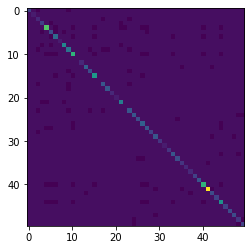

In [173]:
# plt.imshow(L[:50,:50])

In [174]:
L.shape

(4658, 4658)

In [175]:
A.shape

(4658, 4658)

In [176]:
kernel_cav = np.matmul(cavs_sorted_t.T, cavs_sorted_t)
# #the kernel should have a diagonal of 1s
#plt.imshow(kernel_cav)

In [177]:
kernel_glove = np.matmul(glove_sorted_t.T, glove_sorted_t)
#plt.imshow(kernel_glove)

In [178]:
K = linalg.block_diag(kernel_cav, kernel_glove)

In [179]:
# plt.imshow(K)

In [180]:
KA = np.matmul(K,A)
KB = np.matmul(K,B)

KAK = np.matmul(KA, K)
KBK = np.matmul(KB, K)

In [181]:
# plt.imshow(KAK)

Solve the generalized eigenvalue decomposition

In [182]:
rank_A = np.linalg.matrix_rank(KAK)
rank_B = np.linalg.matrix_rank(KBK)

In [183]:
n_eigs = 16
ALPHA, LAMBDA,n_eig = gen_eig(KAK, KBK, 'LM', n_eigs, rank_A, rank_B)

Calculating d and v
Calculation inverse of B


Sort the eigenvalues and vectors

In [184]:
lambda_idxs = np.diag(LAMBDA).argsort()
LAMBDA = np.sort(np.diag(LAMBDA))
LAMBDA = LAMBDA.reshape(LAMBDA.shape[0],1)

In [185]:
LAMBDA

array([[0.92610638],
       [0.9321975 ],
       [0.93591363],
       [0.93942988],
       [0.94384563],
       [0.94837353],
       [0.95341985],
       [0.95353004],
       [0.96770596],
       [0.99004118],
       [1.01378277],
       [1.0204295 ],
       [1.03449132],
       [1.04181174],
       [1.14397314],
       [1.66376368]])

In [186]:
ALPHA = ALPHA[:, lambda_idxs]

Divide the eigenvectors over the 2 datasets

In [187]:
E1 = ALPHA[:n1, :] #eigenvectors for the first dataset (CAV)
E2 = ALPHA[n1:, :] #eigenvectors for the second dataset (GloVe)

Rotate axis is necessary

In [188]:
sourceXpInv = (-1 * np.matmul(E1.T, kernel_cav)).T
sourceXp = np.matmul(E1.T, kernel_cav).T
targetXp = np.matmul(E2.T, kernel_glove).T

In [189]:
sourceXpInv = stats.zscore(sourceXpInv)
sourceXp = stats.zscore(sourceXp)
targetXp = stats.zscore(targetXp)

In [190]:
sourceXpInv.shape

(1649, 16)

In [191]:
ErrRec = np.zeros((n1, ALPHA.shape[1]))
ErrRecInv = np.zeros((n1, ALPHA.shape[1]))

In [192]:
m1 = np.zeros((n1, ALPHA.shape[1]))
m1inv = np.zeros((n1, ALPHA.shape[1]))
m2 = np.zeros((n1, ALPHA.shape[1]))

In [193]:
cls = np.arange(n1).reshape(-1,1)

Compare the error of the inverted eigenvectors and the normal eigenvectors

In [194]:
for j in range(ALPHA.shape[1]):
    for i in range(n1):
        m1inv[i,j] = np.mean(sourceXpInv[i, j])
        #print('m1inv: ', m1inv)
        m1[i,j] = np.mean(sourceXp[i, j])
        #print('m1: ', m1)
        m2[i,j] = np.mean(targetXp[i, j])
        #print('m2: ', m2)
        
        ErrRec[i,j] = np.square(np.power(np.mean(sourceXp[i, j]) - np.mean(targetXp[i, j]), 2))
        
        ErrRecInv[i,j] = np.square(np.power(np.mean(sourceXpInv[i, j]) - np.mean(targetXp[i, j]),2))
        


In [195]:
Sc = ErrRec.max(axis=0) > ErrRecInv.max(axis=0)

In [196]:
Sc

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True])

Invert axis if necessary

In [197]:
ALPHA[:n1, Sc] = ALPHA[:n1, Sc] * -1

In [198]:
NF = 100

In [199]:
nVectLin = min(NF, rank_B)
nVectLin = min(nVectLin, rank_A)

Transform data

In [200]:
T1 = cavs_sorted_t.shape[1]
T2 = glove_sorted_t.shape[1]

for Nf in range(nVectLin):
    E1 = ALPHA[:n1, :Nf+1]
    E2 = ALPHA[n1:, :Nf+1]
    
    Phi1toF = np.matmul(E1.T, kernel_cav)
    Phi2toF = np.matmul(E2.T, kernel_glove)
    
    Phi1TtoF = np.matmul(E1.T, kernel_cav) #KT1?
    Phi2TtoF = np.matmul(E2.T, kernel_glove) #KT2?
    
    m1 = np.mean(Phi1toF.T, axis = 0)
    m2 = np.mean(Phi2toF.T, axis = 0)
    s1 = np.std(Phi1toF.T, axis = 0)
    s2 = np.std(Phi2toF.T, axis =0)
    
    #Phi1toF = stats.zscore(Phi1toF).T
    #Phi2toF = stats.zscore(Phi2toF).T
    
    Phi1TtoF = np.divide((Phi1TtoF.T - np.matlib.repmat(m1, T1, 1)), 
                         np.matlib.repmat(s1, T1, 1)).T
    
    Phi2TtoF = np.divide((Phi2TtoF.T - np.matlib.repmat(m2, T2 ,1)),
                         np.matlib.repmat(s2, T2, 1)).T

In [201]:
# Phi1TtoF_Lin = Phi1TtoF
# Phi2TtoF_Lin = Phi2TtoF

# Phi1TtoF_Lin = scale(Phi1TtoF, axis=1)
# Phi2TtoF_Lin = scale(Phi2TtoF, axis=1)

# Phi1TtoF_Lin = normalize(Phi1TtoF_Lin, axis=0)
# Phi2TtoF_Lin = normalize(Phi2TtoF_Lin, axis=0)


Phi1TtoF_Lin = normalize(Phi1TtoF, axis = 0)
Phi2TtoF_Lin = normalize(Phi2TtoF, axis = 0)

# Phi1TtoF_Lin = stats.zscore(Phi1TtoF, axis = 0)
# Phi2TtoF_Lin = stats.zscore(Phi2TtoF, axis = 0)


Text(0.08559132640313603, 0.061156288803459274, 'launch')

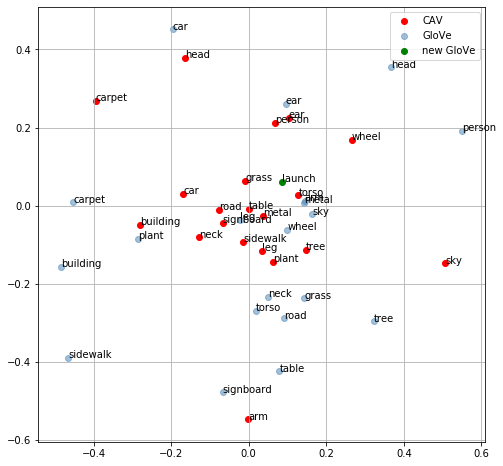

In [202]:
num_concepts = 20
new_glove = 1000 #

plt.figure(figsize=(8,8))
plt.grid()
plt.scatter(Phi1TtoF_Lin[0,:num_concepts], Phi1TtoF_Lin[1,:num_concepts], label = 'CAV', color = 'red')
plt.scatter(Phi2TtoF_Lin[0,:num_concepts], Phi2TtoF_Lin[1,:num_concepts], label = 'GloVe', color = 'steelblue', alpha=0.5)
plt.scatter(Phi2TtoF_Lin[0,n_samples + new_glove], Phi2TtoF_Lin[1,n_samples + new_glove], label = 'new GloVe', color='green')
#plt.xlim([-2.5,2.5])
#plt.ylim([-2.5, 2.5])


plt.legend()

for ii, txt in enumerate(embedding_concepts[:num_concepts]):
    plt.annotate(txt, (Phi1TtoF_Lin[0,ii], Phi1TtoF_Lin[1,ii]))
    plt.annotate(txt, (Phi2TtoF_Lin[0,ii], Phi2TtoF_Lin[1,ii]))

plt.annotate(glove_no_cav_concept_nneigh[new_glove], (Phi2TtoF_Lin[0,n_samples + new_glove], Phi2TtoF_Lin[1,n_samples+new_glove]))

### Validate the manifold alignment

Cosine similarty

In [204]:
counter = 0
print('MU:', MU)
print('LANBDA:', LANBDA,'\n')
for i in range(n_samples):
    cosim = cosine_similarity(Phi2TtoF_Lin.T, Phi1TtoF_Lin.T[i].reshape(-1,16))
    ixs = cosim.argsort(axis=0)[::-1][0:10]
    print('Transformed CAV concept:',embedding_concepts[i])
    print('Closest aligned transformed GloVe concepts:')
    print('-------')
    for j in ixs:
        try:
            print(glove_sorted_concept[j.item()])
        except:
            IndexError
    print('\n')

# print the concepts which do are not closest aligned to their corresponding concept in the other dataset.
#     if embedding_concepts[i] != glove_sorted_concept[ixs[0].item()]:
#         counter +=1
#         print(counter, embedding_concepts[i])

MU: 0.8
LANBDA: 0.5 

Transformed CAV concept: sky
Closest aligned transformed GloVe concepts:
-------
7-5
sink
scoring
prostitution
highs
mixed-use
imam
pretax
archaeological
3-wood


Transformed CAV concept: tree
Closest aligned transformed GloVe concepts:
-------
pulpit
water
crust
sandbox
sling
gun
windshield
room
hose
tree


Transformed CAV concept: building
Closest aligned transformed GloVe concepts:
-------
collection
feet
locomotive
fire
sidewalk
building
outer
built
display
faucet


Transformed CAV concept: person
Closest aligned transformed GloVe concepts:
-------
shafts
court
canvas
trailer
facing
windscreen
torsos
ear
officials
threat


Transformed CAV concept: head
Closest aligned transformed GloVe concepts:
-------
faces
head
courtrooms
vehicles
grasslands
monuments
granaries
bush
image
erected


Transformed CAV concept: leg
Closest aligned transformed GloVe concepts:
-------
garage
man
where
platform
even
court
wearing
hand
farm
home


Transformed CAV concept: torso
Clos

Transformed CAV concept: screen
Closest aligned transformed GloVe concepts:
-------
islands
snows
boiling
memorials
moccasin
commemorating
southbound
excavating
rocking
cemeteries


Transformed CAV concept: pillar
Closest aligned transformed GloVe concepts:
-------
thoroughfare
plank
framework
mirrored
strays
crevasse
orbit
strolling
pitchers
smokehouse


Transformed CAV concept: bicycle
Closest aligned transformed GloVe concepts:
-------
pane
1-732-390-4697
punk
bee
bicycle
deployment
eden
wrap-around
sunglass
fecund


Transformed CAV concept: stove
Closest aligned transformed GloVe concepts:
-------
officials
play
3.6730
8.2767
seawater
where
platform
waste
bottom
gun


Transformed CAV concept: wing
Closest aligned transformed GloVe concepts:
-------
antarctic
imam
handrail
mills
scoring
313.222.2260
coffeemaker
flu
universe
asleep


Transformed CAV concept: roof
Closest aligned transformed GloVe concepts:
-------
3.6730
where
platform
man
even
8.2767
grounds
officials
seawater
next


Transformed CAV concept: canopy
Closest aligned transformed GloVe concepts:
-------
platform
skirts
corner
meat
playpen
nearby
area
closed
drop
toward


Transformed CAV concept: sheep
Closest aligned transformed GloVe concepts:
-------
jaw
two-story
neighborhood
ruling
1-732-390-4697
squadron
pornographic
liquidity
firefighters
stowed


Transformed CAV concept: concrete
Closest aligned transformed GloVe concepts:
-------
antarctic
imam
deputy
flu
futures
bat-signal
313.222.2260
pornographic
actors
towels


Transformed CAV concept: bookcase
Closest aligned transformed GloVe concepts:
-------
bookcase
non-human
wharf
wire
toyshop
gown
two-room
patriots
rowed
mountains


Transformed CAV concept: bedclothes
Closest aligned transformed GloVe concepts:
-------
asleep
peacekeeping
tactics
necropolis
lands
infield
controlling
grasses
metals
bets


Transformed CAV concept: cow
Closest aligned transformed GloVe concepts:
-------
bottom
skirts
platform
case
toward
right
playpen
meat
areas
even




38-11
street
case
skylight
farm
sidewalk
right
computer
.
fire


Transformed CAV concept: net
Closest aligned transformed GloVe concepts:
-------
platform
where
playpen
microwave
niches
skirts
right
officials
display
bottom


Transformed CAV concept: shirt
Closest aligned transformed GloVe concepts:
-------
arches
waterfall
iron
domes
breakwater
mist
farmers
vehicle
boots
footwear


Transformed CAV concept: parlor
Closest aligned transformed GloVe concepts:
-------
imam
antarctic
scoring
bets
pane
asleep
chelate
towels
smokehouse
ranked


Transformed CAV concept: cradle
Closest aligned transformed GloVe concepts:
-------
antarctic
imam
futures
rat-man
313.222.2260
10-story
towels
guitarist
promenade
asleep


Transformed CAV concept: closet
Closest aligned transformed GloVe concepts:
-------
church
minivans
sacristy
halls
audience
napkin
sediment
sandbars
dome
burners


Transformed CAV concept: beach
Closest aligned transformed GloVe concepts:
-------
antarctic
edible
coffeemaker
mad
ha

Transformed CAV concept: auditorium
Closest aligned transformed GloVe concepts:
-------
auditorium
audience
spectators
gymnasium
auditoriums
hall
ballet
department
ceremony
arena


Transformed CAV concept: tower
Closest aligned transformed GloVe concepts:
-------
palm
soda
towers
manufacturer
drawer
ornate
pantries
350-degree
lamppost
concrete


Transformed CAV concept: tire
Closest aligned transformed GloVe concepts:
-------
promenade
files
bandaged
poster
blades
aileron
goals
railways
skating
framework


Transformed CAV concept: merchandise
Closest aligned transformed GloVe concepts:
-------
roots
par-4
punk
retailer
unloads
humanitarian
jockey
tread
davenport
aileron


Transformed CAV concept: playground
Closest aligned transformed GloVe concepts:
-------
platform
built
piping
collection
playground
bleachers
fire
playpen
garage
threat


Transformed CAV concept: plaza
Closest aligned transformed GloVe concepts:
-------
imam
antarctic
fur
asleep
stockade
bat-signal
313.222.2260
scorin

classrooms
stowed


Transformed CAV concept: cemetery
Closest aligned transformed GloVe concepts:
-------
banquet
antarctic
malfunction
boulevard
w.
springs
manufacturer
plaza
deputy
guitarist


Transformed CAV concept: windmill
Closest aligned transformed GloVe concepts:
-------
water
table
crust
gun
inundated
officials
road
farm
reservoir
balustrade


Transformed CAV concept: mill
Closest aligned transformed GloVe concepts:
-------
rooms
shotgun
street
build
manse
organ
boardwalk
mill
fires
campus


Transformed CAV concept: sauna
Closest aligned transformed GloVe concepts:
-------
bat-signal
deputy
flu
imam
framed
futures
antarctic
313.222.2260
10-story
tighten


Transformed CAV concept: mansion
Closest aligned transformed GloVe concepts:
-------
mansion
dinner
bedroom
drought
hillside
ornate
buried
mansions
sandstone
farmhouse


Transformed CAV concept: courtroom
Closest aligned transformed GloVe concepts:
-------
hedge
archaeological
imam
darkness
frozen
7-5
slave
mezzanine
polypho

In [205]:
counter = 0
print('MU:', MU)
print('LANBDA:', LANBDA,'\n')
for i in range(n_samples):
    cosim = cosine_similarity(Phi2TtoF_Lin.T, Phi2TtoF_Lin.T[i].reshape(-1,16))
    ixs = cosim.argsort(axis=0)[::-1][0:10]
    print('Transformed Glove concept:', embedding_concepts[i])
    print('Closest aligned GloVe concepts in common feature space:')
    print('-------')
    for j in ixs:
        try:
            print(glove_sorted_concept[j.item()])
        except:
            IndexError
    print('\n')

MU: 0.8
LANBDA: 0.5 

Transformed Glove concept: sky
Closest aligned GloVe concepts in common feature space:
-------
sky
bogs
waterfall
photo
shower
players
burning
bog
tolling
dashboard


Transformed Glove concept: tree
Closest aligned GloVe concepts in common feature space:
-------
tree
watercolor
pulpit
aqueduct
accessories
farmhouse
drought
microwaves
tower
inn


Transformed Glove concept: building
Closest aligned GloVe concepts in common feature space:
-------
building
trash
microphones
spillway
faucet
roof
silt
rooftop
microwave
foothills


Transformed Glove concept: person
Closest aligned GloVe concepts in common feature space:
-------
person
breakwater
shadows
sinking
court
pillows
diner
head
skillet
products


Transformed Glove concept: head
Closest aligned GloVe concepts in common feature space:
-------
head
t-neck
former
sash
person
moped
laundry
pitch
chalet
memoir


Transformed Glove concept: leg
Closest aligned GloVe concepts in common feature space:
-------
leg
schoolyar

couches
vodka
saltwater
oven
corpse


Transformed Glove concept: body
Closest aligned GloVe concepts in common feature space:
-------
body
wooden
churchyard
tubs
roof
farms
telephones
mouth
fridge
window


Transformed Glove concept: pillow
Closest aligned GloVe concepts in common feature space:
-------
pillow
pendant
pillows
midtown
easel
roses
spritzing
phone
duvet
horse


Transformed Glove concept: headboard
Closest aligned GloVe concepts in common feature space:
-------
headboard
overpass
consulates
gristmill
herd
storefront
counter
eiderdown
equipment
kindergarten


Transformed Glove concept: stairs
Closest aligned GloVe concepts in common feature space:
-------
stairs
knee
sitting
lobbies
curve
quadriplegic
championship
singer
bike
wheelchair


Transformed Glove concept: cat
Closest aligned GloVe concepts in common feature space:
-------
cat
flowering
lorry
pots
duvet
chandeliers
sinks
apartment
sea
chicken


Transformed Glove concept: plate
Closest aligned GloVe concepts in commo

Transformed Glove concept: counter
Closest aligned GloVe concepts in common feature space:
-------
counter
stocked
chef
delis
headboard
shores
interrogatory
planted
sacrificial
shore


Transformed Glove concept: wardrobe
Closest aligned GloVe concepts in common feature space:
-------
wardrobe
desk
sermons
freeway
lake
keyboard
floes
dinner
paddle
sculling


Transformed Glove concept: computer
Closest aligned GloVe concepts in common feature space:
-------
computer
located
sacristy
elk
hayfield
canyon
dances
frescoes
meat
airline


Transformed Glove concept: palm
Closest aligned GloVe concepts in common feature space:
-------
palm
villa
skyscraper
ornate
tango
humankind
ventilation
banquet
fur
plaza


Transformed Glove concept: bus
Closest aligned GloVe concepts in common feature space:
-------
bus
buses
transit
memoir
books
herds
dolmens
ring
crossing
commuter


Transformed Glove concept: microwave
Closest aligned GloVe concepts in common feature space:
-------
microwave
pontoon
grands

Transformed Glove concept: park
Closest aligned GloVe concepts in common feature space:
-------
park
rock
gardens
carousels
lunchroom
trains
radio
ball
futons
bicentennial


Transformed Glove concept: mountain
Closest aligned GloVe concepts in common feature space:
-------
mountain
overlooks
cypress
peaks
intersections
planters
hill
cherry
sloping
earthen


Transformed Glove concept: waterfall
Closest aligned GloVe concepts in common feature space:
-------
waterfall
sky
cans
acrid
towel
burning
bogs
sniper
spoon
playthings


Transformed Glove concept: guitar
Closest aligned GloVe concepts in common feature space:
-------
guitar
semiautomatic
backyard
kitchen
helicopter
platforms
lectern
lawn
baroque
knife


Transformed Glove concept: foliage
Closest aligned GloVe concepts in common feature space:
-------
foliage
boil
manicured
girders
royal
drawers
scissors
masonry
oven
tee


Transformed Glove concept: bouquet
Closest aligned GloVe concepts in common feature space:
-------
bouquet
teac

conversations


Transformed Glove concept: playroom
Closest aligned GloVe concepts in common feature space:
-------
playroom
senate
parlor
chief
armor-piercing
retailer
dug
auto
sword
castle


Transformed Glove concept: mezzanine
Closest aligned GloVe concepts in common feature space:
-------
mezzanine
sneakiness
callers
brackish
camels
perennials
pet
headboard
pizza
leveraged


Transformed Glove concept: menu
Closest aligned GloVe concepts in common feature space:
-------
menu
connects
supermarkets
keyboards
forests
sheeting
mine
caliber
gorilla
cowboys


Transformed Glove concept: valley
Closest aligned GloVe concepts in common feature space:
-------
valley
horizon
county
recycling
bridge
bathtubs
napkins
thatched
airfield
sportswear


Transformed Glove concept: rubbish
Closest aligned GloVe concepts in common feature space:
-------
rubbish
rocks
drawers
palms
ships
lilies
garbage
routes
cushions
half


Transformed Glove concept: auditorium
Closest aligned GloVe concepts in common fe

Transformed Glove concept: ring
Closest aligned GloVe concepts in common feature space:
-------
ring
arches
cradles
single
crosses
bat
coasts
8.2767
jeans
former


Transformed Glove concept: goal
Closest aligned GloVe concepts in common feature space:
-------
goal
liquidity
goals
jar
instrument
gulf
mowing
widget
organs
judge


Transformed Glove concept: delicatessen
Closest aligned GloVe concepts in common feature space:
-------
delicatessen
deli
delis
bakery
mercantile
packers
sacrificial
delicatessens
magnolia
foods


Transformed Glove concept: terrace
Closest aligned GloVe concepts in common feature space:
-------
terrace
overlooks
sand
sloping
windmill
steps
automated
lighthouse
silt
flood


Transformed Glove concept: cemetery
Closest aligned GloVe concepts in common feature space:
-------
cemetery
star
driveways
ornate
bungalow
flood
edible
hills
mansion
suburb


Transformed Glove concept: windmill
Closest aligned GloVe concepts in common feature space:
-------
windmill
tumbling


Transformed Glove concept: niche
Closest aligned GloVe concepts in common feature space:
-------
niche
3.6730
because
telephones
outside
tram
shrub
alternator
using
tapping


Transformed Glove concept: lawn
Closest aligned GloVe concepts in common feature space:
-------
lawn
fountain
machines
backyard
aqueduct
helicopter
antelope
grandstand
archway
guitar


Transformed Glove concept: chalet
Closest aligned GloVe concepts in common feature space:
-------
chalet
caravans
pelts
fence
sawmill
bush
tightly
feline
headstone
vehicles


Transformed Glove concept: guardhouse
Closest aligned GloVe concepts in common feature space:
-------
guardhouse
starry
stadium
staging
commemorating
storerooms
candles
frond
pop
ceremony


Transformed Glove concept: hut
Closest aligned GloVe concepts in common feature space:
-------
hut
tablecloth
clouds
multi-player
40-story
fell
ramshackle
sink
champagne
3-wood


Transformed Glove concept: lagoon
Closest aligned GloVe concepts in common feature space:
------

---

## Manifold Alignment Wang '11

In [47]:
data1 = cavs_sorted_t
data2 = glove_sorted_t

n_samples = len(embedding_concepts)

d1, n1 = data1.shape
d2, n2 = data2.shape

tot_samples = n1 + n2
print("Shape of data1:", data1.shape)
print("Shape of data2:", data2.shape)

Shape of data1: (2048, 1649)
Shape of data2: (300, 3009)


The accuracy of different alignment is stored:
- dimensions keep track of the different dimensions used
- accuracy: is the accuracy of nearest neighbor alignment
- variables: 
    - T1: mu = 0.5
    - T2: mu = 0.6
    - T3: mu = 0.7
    - T4: mu = 0.8
    - T5: mu = 0.9

In [349]:
if os.path.exists('../data/manifold_alignment_accuracy.pickle'):
    with open('../data/manifold_alignment_accuracy.pickle', 'rb') as handle:
        manifold_alignment_accuracy = pickle.load(handle)
        
else:
    manifold_alignment_accuracy = {'dimensions':[],
                                  'CAV_accuracy': [],
                                  'variables': [],
                                  'GloVe_accuracy':[]}
    

In [44]:
Z = linalg.block_diag(data1, data2) #dimensions (d1+d2, n1+n2)

print("Computing neighbors dataset 1")
# create k-Nearest neighbor graph for data structures 

n_neighbors = 10
x1_graph = np.zeros((n1, n1))
for n in trange(n1):
    x1_nn = cosine_similarity(data1.T, data1.T[n].reshape(1,-1))
    x1_nn_ixs = x1_nn.argsort(axis=0)[::-1][1:n_neighbors+1].flatten()
    x1_graph[n,x1_nn_ixs] = 1

    # check if data corresponds:
    if not np.array_equal(np.where(x1_graph[n] == 1)[0], np.sort(x1_nn_ixs)):
        print(n)

print('Computing neighbors dataset 2')
x2_graph = np.zeros((n2, n2))
for c in trange(n2):
    x2_nn = cosine_similarity(data2.T, data2.T[c].reshape(1,-1))
    x2_nn_ixs = x2_nn.argsort(axis=0)[::-1][1:n_neighbors+1].flatten()
    x2_graph[c, x2_nn_ixs] = 1
    if not np.array_equal(np.where(x2_graph[c] == 1)[0], np.sort(x2_nn_ixs)):
        print(c)

Computing neighbors dataset 1



Computing neighbors dataset 2


In [335]:
# Print neighbors in the glove dataset
glove_neighbors_dict = {}
for ix, c in enumerate(glove_sorted_concept):
    glove_cos_neighbors = np.where(x2_graph[ix] ==1)[0]
    glove_neighbors_dict[c] = []

    print(c)
    print('---------')
    for n in np.nditer(glove_cos_neighbors):
        print(glove_sorted_concept[n.item()])
        glove_neighbors_dict[c].append(glove_sorted_concept[n.item()])
    print('\n')
#     break

sky
---------
cloud
clouds
skies
bright
blue
horizon
darkness
dark
sun
lights


tree
---------
flower
fruit
trees
pine
oak
shrubs
planted
trunks
bark
garden


building
---------
tower
buildings
built
construction
houses
constructed
structure
build
brick
demolished


person
---------
someone
man
anyone
woman
one
actually
persons
people
else
somebody


head
---------
arm
body
heads
assistant
chief
headed
director
deputy
chair
hand


leg
---------
arm
neck
legs
thigh
knee
ankle
injury
shoulder
wrist
groin


torso
---------
neck
legs
buttocks
torsos
thighs
abdomen
limbs
pelvis
hips
forearm


table
---------
kitchen
tables
sit
sitting
room
dining
chairs
dinner
side
sat


arm
---------
head
leg
hand
shoulder
wrist
elbow
forearm
arms
right
hands


road
---------
highway
bridge
roads
route
lane
along
intersection
roadway
junction
highways


ear
---------
ears
eye
nose
throat
mouth
jaw
eyes
eardrum
tongue
teeth


grass
---------
ground
pasture
lawn
trees
grasses
lawns
roots
weeds
dirt
turf


me

palm
---------
tree
beach
trees
palms
coconut
groves
fronds
writes
magnolia
mail


bus
---------
car
truck
train
taxi
minibus
trains
rail
commuter
passenger
buses


microwave
---------
stove
oven
refrigerator
ovens
microwaves
infrared
antennas
dish
toaster
radiation


sand
---------
dirt
rocks
dunes
gravel
mud
silt
dust
beaches
sandy
sediment


track
---------
road
train
racing
tracks
speed
song
record
course
race
recording


lid
---------
squeeze
spoon
rack
lids
jar
hinged
removable
clamped
tightly
tabs


skirt
---------
pants
dress
skirts
blouse
pleated
dresses
trousers
gown
chiffon
tunic


skyscraper
---------
building
tower
midtown
skyscrapers
tallest
high-rise
towers
mixed-use
40-story
10-story


snow
---------
mountain
ice
rain
snowfall
fog
winter
sleet
snowstorm
rains
weather


skin
---------
hair
eye
tissue
lesions
flesh
tissues
facial
lungs
pigmentation
bone


coach
---------
assistant
teammates
team
coached
coaches
coaching
football
basketball
manager
players


highway
------

campus
---------
downtown
students
school
campuses
university
college
faculty
student
dormitories
graduate


ruins
---------
buildings
medieval
monuments
ruined
ancient
rubble
temples
archaeological
excavated
destroyed


ring
---------
outer
rings
diamond
trafficking
belt
busted
smuggling
ringing
five-membered
prostitution


goal
---------
kick
goals
scored
scoring
minute
penalty
half
header
striker
score


delicatessen
---------
bookshop
coffeehouse
drugstore
eatery
bakery
deli
delis
pizzeria
delicatessens
pastrami


terrace
---------
balcony
patio
rooftop
overlooking
courtyard
promenade
gardens
terraces
overlooks
terraced


cemetery
---------
memorial
mausoleum
churchyard
interred
buried
cemeteries
burial
graves
interment
graveyard


windmill
---------
lighthouse
mill
watermill
windmills
roundhouse
thatched
smock
gristmill
dovecote
sawmill


mill
---------
creek
windmill
factory
furnace
watermill
gristmill
sawmill
grist
mills
fulling


sauna
---------
tub
jacuzzi
tubs
massage
gym
sau

assistant
---------
head
coach
chief
director
deputy
former
senior
coaching
manager
department


chief
---------
head
top
office
assistant
director
deputy
former
senior
president
official


headed
---------
head
heads
deputy
then
former
along
corner
toward
flew
off


director
---------
head
assistant
chief
deputy
senior
film
manager
editor
department
agency


deputy
---------
head
office
assistant
chief
director
former
senior
department
official
ministry


chair
---------
head
table
seat
heads
sit
sitting
chairs
sat
sits
sofa


hand
---------
arm
then
arms
right
hands
finger
down
touch
well
even


then
---------
.
down
they
way
first
where
got
even
next
off


former
---------
head
top
office
assistant
chief
headed
deputy
senior
president
officials


legs
---------
leg
torso
neck
thighs
abdomen
limbs
hips
chest
shoulders
hind


thigh
---------
leg
knee
ankle
injury
shoulder
wrist
groin
elbow
forearm
chest


knee
---------
leg
neck
thigh
ankle
injury
shoulder
wrist
groin
elbow
forearm




streets
---------
street
downtown
roads
along
sidewalks
avenue
neighborhood
alleys
neighborhoods
city


avenue
---------
street
park
plaza
downtown
intersection
streets
boulevard
midtown
located
thoroughfare


wall
---------
street
roof
fence
market
inside
glass
walls
ceiling
floor
investors


neighborhood
---------
street
village
downtown
streets
apartment
area
nearby
outskirts
neighborhoods
suburb


market
---------
street
products
investment
investors
profits
futures
prices
sales
decline
marketplace


corner
---------
ball
side
avenue
inside
front
kick
flicked
located
outside
header


boulevard
---------
highway
plaza
downtown
intersection
avenue
freeway
terminus
expressway
promenade
thoroughfare


midtown
---------
skyscraper
plaza
downtown
avenue
apartment
townhouse
subway
waterfront
hotel
storefront


beds
---------
bed
sleeping
bunk
pillows
rooms
floors
bathrooms
toilets
tents
cabins


sleeping
---------
bed
bedroom
tent
sitting
room
slept
sleep
asleep
tents
bags


slept
-------

prints
---------
images
canvases
painting
watercolor
watercolors
collections
collection
photographs
sculptures
paintings


hind
---------
torso
tail
legs
abdomen
limbs
tails
wings
snout
paws
hoof


moccasin
---------
paw
creek
aqueduct
butte
guardrail
leopard
soapy
piping
3.6730
saguaro


alligator
---------
paw
elephant
leopard
raccoon
gator
shark
saltwater
swamp
rhino
giraffe


raccoon
---------
dog
cat
fur
alligator
rabbit
rat
mink
pelts
beaver
elk


hoof
---------
paw
thigh
pelvis
forearm
nose
paws
hind
bone
perforated
flaps


bear
---------
paw
dog
mountain
elephant
leopard
dogs
animal
animals
elk
lion


black-figure
---------
vase
attic
easel
earthenware
vases
red-figure
wiper
tempera
fresco
baptistery


red-figure
---------
vase
attic
pottery
earthenware
stoneware
vases
black-figure
tempera
fresco
15th-century


fa
---------
vase
cup
championship
champions
finals
matches
semifinal
football
final
villa


figurine
---------
ceramic
vase
porcelain
earthenware
figurines
vases
statue

facade
---------
brick
porch
walls
marble
nave
stucco
portico
three-story
two-story
arches


roofed
---------
roof
brick
roofs
tiled
huts
three-story
thatched
two-story
ramshackle
shacks


substitutes
---------
bench
meat
meal
starters
rested
juice
butter
minute
striker
relievers


locker
---------
bench
bathroom
hallway
lockers
room
upstairs
dugout
rooms
teammates
gym


starters
---------
bullpen
quarterback
lineup
teammates
players
pitching
pitcher
pitchers
relievers
starter


lineup
---------
bench
bullpen
starters
rested
team
game
players
pitching
hitter
starter


teammates
---------
bench
coach
dugout
locker
starters
team
teams
fans
coaches
players


rested
---------
bench
bullpen
thigh
knee
ankle
injury
shoulders
starters
lineup
motionless


boats
---------
boat
ship
waters
vessel
yacht
sailing
fishing
sail
ships
vessels


vessel
---------
boat
ship
sank
boats
sail
ships
vessels
aboard
cargo
freighter


yacht
---------
boat
ship
boats
vessel
capsized
sailing
sailboat
sail
ships
s

statue
---------
pedestal
monument
marble
obelisk
sculpted
plaque
mural
erected
sculpture
sculptures


marble
---------
monument
brick
granite
slab
ornate
statue
sculpted
stucco
limestone
sandstone


obelisk
---------
pedestal
monument
granite
plinth
statue
marble
plaque
erected
commemorating
inscribed


sculpted
---------
gilded
statue
marble
decorated
sculptural
stucco
bas-relief
sculpture
sculptures
painted


tripod
---------
pedestal
camera
pelvis
pedestals
antennas
antenna
sling
handrail
turret
paddles


octagonal
---------
cupola
spire
arched
semi-circular
nave
portico
three-story
two-story
arches
polygonal


plaque
---------
monument
gravestone
statue
marble
erected
memorial
commemorating
headstone
inscription
inscribed


fireplaces
---------
fireplace
bedrooms
stoves
bathrooms
skylights
chandeliers
mantels
paneling
tubs
cabins


chimney
---------
stove
roof
fireplace
staircase
brick
furnace
fireplaces
masonry
radiator
cupola


hearth
---------
stove
fireplace
patio
stoves
furna

sauce


hinged
---------
lid
canopy
fuselage
planks
mirrors
door
doors
undercarriage
welded
superstructure


removable
---------
lid
dashboard
stainless
rack
fiberglass
lids
portable
encased
perforated
racks


clamped
---------
lid
shutters
tightly
tabs
welded
restrictions
tighten
tighter
strict
tightened


tightly
---------
lid
controls
inside
squeeze
airtight
clamped
controlled
tighter
tightened
wrapped


tabs
---------
lid
dashboard
drawer
folder
lids
clamped
tightly
menus
tighten
tighter


skirts
---------
skirt
pants
dress
blouse
pleated
dresses
trousers
chiffon
tunic
sleeves


blouse
---------
skirt
pants
skirts
pleated
dresses
trousers
chiffon
tunic
sweater
pantsuit


pleated
---------
skirt
pants
skirts
blouse
dresses
trousers
chiffon
tunic
pantsuit
sleeves


dresses
---------
skirt
pants
dress
outfits
skirts
blouse
pleated
trousers
gown
chiffon


trousers
---------
skirt
shirt
jacket
pants
skirts
blouse
tunic
jeans
khaki
sweater


gown
---------
skirt
jacket
dress
blouse
pleat

photos
---------
videos
picture
images
photograph
photo
video
pictures
clips
photographs
footage


espresso
---------
mug
drink
vodka
soda
decaffeinated
sandwiches
dessert
cream
chocolate
sauce


pint
---------
bottle
bottles
cans
beer
vodka
glasses
soda
cups
jar
cream


grinning
---------
mug
sitting
eyes
strolling
wearing
lounging
handkerchief
photograph
plastered
paraded


decaffeinated
---------
mug
bidet
drink
mugs
espresso
pint
teabag
spritzing
coffeemaker
liters


footwear
---------
leather
apparel
shoes
accessories
garments
handbags
clothing
sportswear
garment
textiles


sportswear
---------
apparel
clothes
accessories
handbags
clothing
footwear
retailer
jeans
menswear
ready-to-wear


retailer
---------
apparel
supermarket
clothing
retailers
manufacturer
stores
store
grocery
supermarkets
chain


garment
---------
leather
apparel
factory
factories
silk
garments
clothing
footwear
textiles
textile


textiles
---------
apparel
carpets
ceramics
products
garments
clothing
footwear
te

foam
---------
ceramic
rubber
plastic
mattress
cushions
tiles
fiberglass
coated
latex
insulation


tear
---------
rubber
smoke
rocks
crowd
coated
bullets
burning
firing
fired
gunfire


cameras
---------
camera
screens
images
phones
cellphones
video
digital
microphones
lenses
photographers


video
---------
camera
videos
images
recording
digital
pictures
broadcast
television
clips
footage


microphone
---------
ear
keyboard
camera
phone
cellphone
antenna
cameras
microphones
recorder
lectern


digital
---------
computer
camera
phones
computers
software
technology
electronic
cameras
video
wireless


microphones
---------
camera
ears
telephones
phones
antennas
portable
notebooks
cameras
microphone
recorders


lenses
---------
mirror
camera
eye
metallic
mirrors
lens
glasses
infrared
cameras
acrylic


photographers
---------
camera
photograph
photo
photos
spectators
cameras
pictures
photographs
camped
fashion


pictures
---------
videos
picture
movies
images
posters
photograph
photo
photos
p

using
---------
actually
hand
they
taken
way
well
systems
because
even
equipment


machinery
---------
construction
factory
factories
manufacturing
machines
textiles
textile
equipment
goods
agricultural


heavy
---------
metal
snow
machine
rain
snowfall
fog
rains
thick
loads
massive


manor
---------
castle
abbey
mansion
chapel
cottage
castles
priory
farmhouse
grange
moated


castles
---------
castle
manor
fortress
medieval
monasteries
temples
mansions
palaces
fortification
abbeys


fortress
---------
castle
ruins
built
walls
overlooking
castles
medieval
ramparts
fortification
hilltop


medieval
---------
castle
ruins
castles
fortress
monastery
monastic
baroque
15th-century
ancient
fortification


château
---------
castle
abbey
mansion
manor
castles
convent
palatial
grange
moated
manse


town
---------
village
where
area
situated
nearby
outskirts
villages
near
towns
city


situated
---------
village
constructed
sits
area
connects
adjacent
located
town
overlooks
near


rebuilt
---------

38-11
---------
eiderdown
0-fer
sneakiness
83-58
3.6730
ridging
85-69
8.2767
1,400-pound
whistle-blowing


hyphenates
---------
eiderdown
nonentity
3.6730
8.2767
romancer
pshaw
rock-band
damningly
rat-man
quavery


8.2767
---------
eiderdown
83-58
3.6730
38-11
romancer
teabag
1,400-pound
somnambulist
2217
2402


romancer
---------
eiderdown
finite-state
sneakiness
3.6730
hyphenates
8.2767
rock-band
whistle-blowing
go-getter
bunkmate


bridges
---------
bridge
buildings
constructed
roads
highways
connecting
pontoon
rivers
viaducts
dams


crossing
---------
road
bridge
river
route
along
intersection
connecting
tunnel
crosses
near


pontoon
---------
boat
bridge
trestle
boats
moored
bridges
footbridge
superstructure
cable-stayed
trestles


footbridge
---------
bridge
viaduct
trestle
walkway
balustrade
escalators
pedestrian
overpass
underpass
cable-stayed


crosses
---------
highway
bridge
river
route
intersection
roadway
junction
terminus
connects
crossing


span
---------
bridge
deck
con

ejector
---------
washer
bidet
draperies
upholstery
lavatory
dryer
dryers
nozzles
paddles
aileron


pshaw
---------
eiderdown
bidet
fussiness
sneakiness
3.6730
teabag
interrogatory
coffeemaker
rock-band
bunkmate


coffeemaker
---------
bidet
kickstand
footstool
playpen
fridge
dishwasher
toaster
espresso
dryers
3.6730


fermenter
---------
bidet
lamppost
10-by-10-foot
3.6730
teabag
floorboard
conjoin
spiffier
quavery
scruffier


toothbrush
---------
toilet
napkin
heater
faucet
towel
typewriter
conditioner
towels
razor
scissors


stocked
---------
refrigerator
pantry
shops
shelves
fridge
cupboards
stores
store
grocery
supermarkets


pantries
---------
pantry
soup
kitchens
cupboards
closets
basements
delis
delicatessens
storehouses
convents


railroad
---------
train
railway
trains
rail
freight
terminus
connecting
railways
locomotive
railroads


railways
---------
railway
roads
highways
trains
rail
freight
tram
railroad
locomotive
railroads


locomotive
---------
train
railway
engine
trai

fresco
---------
altarpiece
canvases
painting
mural
tempera
frescoes
triptych
annunciation
painted
paintings


annunciation
---------
altar
altarpiece
basilica
cathedral
sacristy
convent
frescoes
triptych
fresco
baptistery


baroque
---------
altarpiece
facade
ornate
harpsichord
medieval
cathedral
ornamentation
architectural
frescoes
15th-century


15th-century
---------
altarpiece
stained-glass
octagonal
cupola
medieval
sacristy
nave
frescoes
baroque
baptistery


bas-relief
---------
altarpiece
stained-glass
depicting
sculpted
mural
sculptural
altarpieces
triptych
sculpture
sculptures


wipers
---------
washer
windscreen
dashboard
brakes
washers
wiper
windshield
headlight
headlights
speedometer


windshields
---------
windscreen
parked
roofs
panes
sunroofs
washers
windshield
kneecaps
driveways
dashboards


headlight
---------
windscreen
dashboard
radiator
washers
wiper
windshield
wipers
headlights
fairing
chrome


headlights
---------
windscreen
dashboard
lights
wheels
mirrors
radiato

campgrounds
---------
campsite
restrooms
camping
parks
picnic
cabins
campground
campsites
campers
cottages


campers
---------
campsite
tents
camping
picnic
cabins
camper
campground
campsites
campgrounds
climbers


camped
---------
tent
campsite
slept
riverbank
tents
makeshift
encampment
encampments
outside
outskirts


bathing
---------
toilet
sauna
shower
clothes
wearing
tub
lounging
attire
beaches
baths


showering
---------
shower
sidewalks
tub
lounging
restroom
toilets
heaps
windshields
bathing
burying


bath
---------
bed
bathroom
sauna
shower
tub
jacuzzi
tubs
towels
massage
baths


meteor
---------
sky
earth
cloud
clouds
shower
planet
spacecraft
plume
thunderstorms
showers


aqueducts
---------
aqueduct
irrigation
drainage
embankments
fountains
bridges
waterworks
viaducts
dams
reservoirs


racecourse
---------
horse
aqueduct
thoroughbred
breeders
derby
jockey
paddock
racetrack
handicap
woodbine


sewer
---------
water
sewage
potable
drainage
drain
toilets
pipe
garbage
landfill
wa

farms
---------
farm
poultry
chickens
cattle
livestock
farmland
farmers
farming
dairy
orchards


farmers
---------
farm
livestock
rural
villagers
farms
agricultural
farming
farmer
agriculture
subsidies


agricultural
---------
farm
irrigation
livestock
farmland
rural
farmers
farming
agriculture
subsidies
forestry


farming
---------
farm
irrigation
livestock
farmland
rural
farms
farmers
agricultural
farmer
agriculture


dairy
---------
farm
foods
meat
products
poultry
cattle
cows
livestock
farms
farmers


farmer
---------
sheep
farm
landowner
grower
farms
farmers
agricultural
farming
dairy
agriculture


agriculture
---------
farm
irrigation
livestock
rural
farmers
agricultural
farming
subsidies
ministry
forestry


subsidies
---------
farm
income
revenues
prices
restrictions
emissions
farmers
agricultural
farming
agriculture


arches
---------
arch
pillars
facade
octagonal
domes
spire
arched
semi-circular
nave
portico


nemesis
---------
arch
former
feline
favorite
star
shadow
foe
rival

eden
---------
park
valley
terrace
orchard
garden
gardens
hills
meadow
grove
prairie


forests
---------
forest
trees
vegetation
grassland
grasslands
wetlands
mangrove
swamps
woodland
habitat


woodland
---------
pasture
forest
vegetation
hills
grassland
grasslands
meadows
forests
habitat
heathland


forestry
---------
forest
livestock
hectares
department
agricultural
farming
agriculture
ministry
forests
wildlife


wildlife
---------
forest
animal
birds
animals
parks
wetlands
wetland
wilderness
forests
habitat


habitat
---------
forest
vegetation
grassland
grasslands
wetlands
wetland
mangrove
freshwater
forests
wildlife


stall
---------
bathroom
toilet
shower
stalls
room
door
locker
restroom
divider
shop


hawkers
---------
sidewalk
shops
stalls
sidewalks
vendors
kiosk
souvenirs
kiosks
shacks
souvenir


kiosks
---------
shops
stalls
vendors
restrooms
booths
kiosk
automated
supermarkets
malls
eateries


shacks
---------
roofed
makeshift
huts
squalid
hovels
thatched
shantytowns
shanty


paint
---------
canvas
tile
glass
walls
latex
canvases
painting
painted
acrylic
paintings


ashore
---------
boat
coast
ship
shore
waters
boats
capsized
shores
beaches
waves




In [48]:
print('Building Laplacians')
# create topology Laplacian
W = linalg.block_diag(x1_graph, x2_graph)
W = (W + W.T)/2

# create simmilarity matrix
Ws = np.zeros((tot_samples, tot_samples))

Ws1 = np.eye(n1)
Ws2 = np.eye(n2)
Ws3 = np.eye(n_samples)

Ws[:n1, :n1] = Ws1
Ws[n1:, n1:] = Ws2
Ws[n1:(n1+n_samples), :n_samples] = Ws3
Ws[:n_samples, n1:(n1+n_samples)] = Ws3

Ws = Ws + np.eye(Ws.shape[0])

#create dissimilarity matrix
Wd = np.ones((n1+n2, n1+n2))
np.fill_diagonal(Wd, 0)

Wd1 = np.ones((n_samples, n_samples))
np.fill_diagonal(Wd1, 0)

Wd[:n_samples, n1:(n1+n_samples)] = Wd1
Wd[n1:(n1+n_samples), :n_samples] = Wd1

Wd = Wd + np.eye(Wd.shape[0])

# normalize data
Sws = sum(sum(Ws))
Swd = sum(sum(Wd))
Sw = sum(sum(W))

Ws = Ws / Sws * Sw
Wd = Wd / Swd * Sw

# extract the diagonals
Dd = np.diag(np.sum(Wd, axis=1))
Ds = np.diag(np.sum(Ws, axis = 1))
D = np.diag(np.sum(W, axis=1))

# create laplacians
Ls = Ds - Ws # graph Laplacian of similarity 
Ld = Dd - Wd # Laplacian of dissimilarity
L = D - W # Laplacian topology/geometry

Building Laplacians


In [86]:
# plt.imshow(Wd[n1:n1+400, :400])

In [601]:
MUW = 0.7
LAMBDAW = 0.5

In [620]:
if MUW == 0.5:
    manifold_alignment_accuracy['variables'].append('T1')
elif MUW == 0.6:
    manifold_alignment_accuracy['variables'].append('T2')
elif MUW == 0.7:
    manifold_alignment_accuracy['variables'].append('T3')
elif MUW == 0.8:
    manifold_alignment_accuracy['variables'].append('T4')
elif MUW == 0.9:
    manifold_alignment_accuracy['variables'].append('T5')


In [621]:
# tune the generalized eigenproblem
A = ((1 - MUW) * L + MUW * Ls) + LAMBDAW * np.eye((Ls.shape[0]))
B = Ld

ZA = np.matmul(Z, A)
ZB = np.matmul(Z, B)

ZAZ = np.matmul(ZA, Z.T)
ZBZ = np.matmul(ZB, Z.T)

In [622]:
rank_A = np.linalg.matrix_rank(ZAZ)
rank_B = np.linalg.matrix_rank(ZBZ)

In [623]:
%%time

start_time = time.monotonic()

#n_eigs = 5, 10, 50, 100, 200, 300, 400, 500

n_eigs = 5
manifold_alignment_accuracy['dimensions'].append(n_eigs)

# V = eigenvectors, D = eigenvalues
V, D, n_eig = gen_eig(ZAZ, ZBZ, 'LM', n_eigs, rank_A, rank_B)

Calculating d and v
Calculation inverse of B



CPU times: user 6min 51s, sys: 5min 14s, total: 12min 6s
Wall time: 3min 11s


In [624]:
D_idxs = np.diag(D).argsort()
D = np.sort(np.diag(D))
D = D.reshape(D.shape[0],1)

V = V[:, D_idxs]

In [625]:
# D

In [626]:
#rotate axis if needed
E1 = V[:d1,:]
E2 = V[d1:,:]

sourceXpInv = (-1 * np.matmul(E1.T, data1)).T
sourceXp = np.matmul(E1.T, data1).T
targetXp = np.matmul(E2.T, data2).T

sourceXpInv = stats.zscore(sourceXpInv)
sourceXp = stats.zscore(sourceXp)
targetXp = stats.zscore(targetXp)

ErrRec = np.zeros((n1, V.shape[1]))
ErrRecInv = np.zeros((n1, V.shape[1]))

m1 = np.zeros((n1, V.shape[1]))
m1inv = np.zeros((n1, V.shape[1]))
m2 = np.zeros((n1, V.shape[1]))

for j in range(V.shape[1]):
    for i in range(n1):
        m1inv[i,j] = np.mean(sourceXpInv[i, j])
        #print('m1inv: ', m1inv)
        m1[i,j] = np.mean(sourceXp[i, j])
        #print('m1: ', m1)
        m2[i,j] = np.mean(targetXp[i, j])
        #print('m2: ', m2)

        ErrRec[i,j] = np.square(np.power(np.mean(sourceXp[i, j]) - np.mean(targetXp[i, j]), 2))

        ErrRecInv[i,j] = np.square(np.power(np.mean(sourceXpInv[i, j]) - np.mean(targetXp[i, j]),2))

Sc = ErrRec.max(axis=0) > ErrRecInv.max(axis=0)
V[:d1, Sc] = V[:d1, Sc] * -1

In [627]:
V.shape

(2348, 5)

In [628]:
d1+d2

2348

In [629]:
T1 = data1.shape[1]
T2 = data2.shape[1]

Nf = d1+d2
E1 = V[:d1, :Nf]
E2 = V[d1:, :Nf]

X1toF = np.matmul(E1.T, data1)
X2toF = np.matmul(E2.T, data2)

m1 = np.mean(X1toF.T, axis = 0)
m2 = np.mean(X2toF.T, axis = 0)
s1 = np.std(X1toF.T, axis = 0)
s2 = np.std(X2toF.T, axis =0)

#Phi1toF = stats.zscore(Phi1toF).T
#Phi2toF = stats.zscore(Phi2toF).T

XT1toF = np.divide((X1toF.T - np.matlib.repmat(m1, T1, 1)), 
                     np.matlib.repmat(s1, T1, 1)).T

XT2toF = np.divide((X2toF.T - np.matlib.repmat(m2, T2 ,1)),
                     np.matlib.repmat(s2, T2, 1)).T


In [630]:
XT1toF.shape

(5, 1649)

In [631]:
XT2toF.shape

(5, 3009)

### Accuracy of alignment

Calculate a accuracy metric of the manifold alignment. The nearest neighbors of the transformed CAVs are calculated and compared with the nearest neighbors of this concept in the GloVe domain. The comparison is based on exact matches and not on semantic similar words

In [632]:
average_nn_accuracy = 0

for p, w in tqdm(enumerate(embedding_concepts)):
    correct_nn = 0
    cos_sim = cosine_similarity(XT2toF.T, XT1toF.T[p].reshape(-1,n_eigs))
    top_10_nn = cos_sim.argsort(axis=0)[::-1][1:11]
    glove_domain_nn = glove_neighbors_dict[w]
    for e in top_10_nn:
        if glove_sorted_concept[e.item()] in glove_domain_nn:
            correct_nn += 1
    correct_nn = correct_nn/10
    average_nn_accuracy += correct_nn
    
average_nn_accuracy /= len(embedding_concepts)
manifold_alignment_accuracy['CAV_accuracy'].append(average_nn_accuracy)

print("CAV to GloVe accuracy: ", round(average_nn_accuracy,3) * 100)


CAV to GloVe accuracy:  0.6


Compare the GloVe neighbors in the common feature space to the GloVe neighbors in the GloVe domain. The accuracy is based on exact matches and not on semantic similar words

In [633]:
glove_glove_accuracy = 0

for p, w in tqdm(enumerate(embedding_concepts)):
    correct_nn = 0
    cos_sim = cosine_similarity(XT2toF.T, XT2toF.T[p].reshape(-1,n_eigs))
    top_10_nn = cos_sim.argsort(axis=0)[::-1][1:11]
    glove_domain_nn = glove_neighbors_dict[w]
    for e in top_10_nn:
        if glove_sorted_concept[e.item()] in glove_domain_nn:
            correct_nn += 1
    correct_nn = correct_nn/10
    glove_glove_accuracy += correct_nn
    
glove_glove_accuracy /= len(embedding_concepts)
manifold_alignment_accuracy['GloVe_accuracy'].append(glove_glove_accuracy)

print("GloVe to GloVe accuracy: ", round(glove_glove_accuracy,3) * 100)


GloVe to GloVe accuracy:  0.8


In [634]:
# manifold_alignment_accuracy['variables']

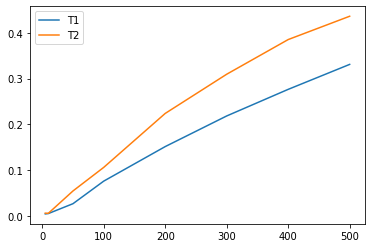

In [635]:
sns.lineplot(x='dimensions', y='CAV_accuracy', hue='variables', data=manifold_alignment_accuracy)

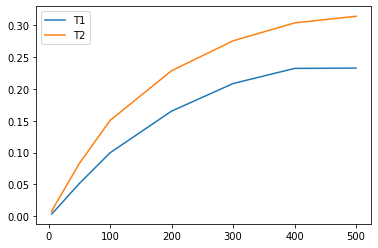

In [636]:
sns.lineplot(x='dimensions', y='GloVe_accuracy', hue = 'variables', data=manifold_alignment_accuracy)

In [637]:
with open('../data/manifold_alignment_accuracy.pickle', 'wb') as handle:
        pickle.dump(manifold_alignment_accuracy, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [619]:
#print CAV neighbors in the common feature space
counter = 0
print("Dim:", n_eigs)
print('MU:', MUW)
print('LANBDA:', LAMBDAW,'\n')
for i in range(n_samples):
    cosim = cosine_similarity(XT2toF.T, XT1toF.T[i].reshape(-1,n_eigs))
    ixs = cosim.argsort(axis=0)[::-1][0:10]
    print('Transformed CAV concept:',embedding_concepts[i])
    print('Closest aligned transformed GloVe concepts:')
    print('-------')
    for j in ixs:
        try:
            print(glove_sorted_concept[j.item()])
        except:
            IndexError
    print('\n')


Dim: 500
MU: 0.6
LANBDA: 0.5 

Transformed CAV concept: sky
Closest aligned transformed GloVe concepts:
-------
sky
heavens
digital
skies
starry
flying
supported
broadcaster
television
earth


Transformed CAV concept: tree
Closest aligned transformed GloVe concepts:
-------
tree
trees
trunks
dinner
tent
shrub
toothbrush
limbs
grosser
telephone


Transformed CAV concept: building
Closest aligned transformed GloVe concepts:
-------
building
buildings
construction
towards
phase
three-story
12-story
laminated
residence
orchards


Transformed CAV concept: person
Closest aligned transformed GloVe concepts:
-------
person
persons
someone
somebody
anyone
one
man
elected
else
rooms


Transformed CAV concept: head
Closest aligned transformed GloVe concepts:
-------
head
heads
chief
deputy
assistant
director
headed
chair
chairs
coach


Transformed CAV concept: leg
Closest aligned transformed GloVe concepts:
-------
leg
semifinal
home
legs
tour
laminate
side
bowling
champions
313.222.2260


Transf

Transformed CAV concept: roof
Closest aligned transformed GloVe concepts:
-------
roof
roofs
excavator
doors
golf
decorative
heavens
equipment
rooftop
billowing


Transformed CAV concept: bench
Closest aligned transformed GloVe concepts:
-------
bench
upstairs
substitutes
downstairs
fountain
areas
railing
broth
lane
clerk


Transformed CAV concept: boat
Closest aligned transformed GloVe concepts:
-------
boat
boats
yacht
sailboat
fishing
capsized
oars
pontoon
rowed
rowing


Transformed CAV concept: desk
Closest aligned transformed GloVe concepts:
-------
desk
desks
drawer
313.222.2260
editor
pacific
photo
wire
armor-piercing
phone


Transformed CAV concept: bird
Closest aligned transformed GloVe concepts:
-------
bird
flu
avian
birds
influenza
virus
outbreaks
migratory
swine
poultry


Transformed CAV concept: leather
Closest aligned transformed GloVe concepts:
-------
leather
boots
shoes
deep
debuted
motorcyclists
passionate
metallic
tannery
chelate


Transformed CAV concept: bathroom


berries
bear
peach
vegetable
bananas


Transformed CAV concept: candle
Closest aligned transformed GloVe concepts:
-------
candle
candles
votive
lit
candlelight
napkin
flickering
snowstorm
incense
lighted


Transformed CAV concept: handbag
Closest aligned transformed GloVe concepts:
-------
handbag
handbags
luggage
woman
quilted
shoes
backpack
bag
constituency
leather


Transformed CAV concept: mug
Closest aligned transformed GloVe concepts:
-------
mug
mugs
photo
picture
wallet
photos
laminates
cans
hustled
framed


Transformed CAV concept: apparel
Closest aligned transformed GloVe concepts:
-------
apparel
footwear
clothing
retailers
textiles
garments
garment
textile
accessories
sportswear


Transformed CAV concept: land
Closest aligned transformed GloVe concepts:
-------
land
lands
garlands
ownership
sofa
pasture
cottonwood
tiled
projectiles
condo


Transformed CAV concept: ball
Closest aligned transformed GloVe concepts:
-------
ball
balls
flicked
corner
bounced
bat
players
kick
de

Transformed CAV concept: roundabout
Closest aligned transformed GloVe concepts:
-------
roundabout
production
courtyard
theater
patio
recycling
garden
departed
embassies
pedestal


Transformed CAV concept: lake
Closest aligned transformed GloVe concepts:
-------
lake
shores
salt
lakes
pond
spectators
winter
saltwater
alpine
cauldron


Transformed CAV concept: barrel
Closest aligned transformed GloVe concepts:
-------
barrel
mercantile
crude
highs
mansions
peaking
delivery
crate
prices
recoil


Transformed CAV concept: ship
Closest aligned transformed GloVe concepts:
-------
ship
vessel
ships
vessels
navy
crew
sail
freighter
sailed
aboard


Transformed CAV concept: house
Closest aligned transformed GloVe concepts:
-------
house
senate
houses
congressional
republicans
congress
democrats
floor
republican
capitol


Transformed CAV concept: bell
Closest aligned transformed GloVe concepts:
-------
bell
taco
bells
peppers
ringer
curve
floral
pacific
dark
author


Transformed CAV concept: exhi

controls
controlled
controlling
control
thermostat
sits
knobs
seats
facial
wears


Transformed CAV concept: island
Closest aligned transformed GloVe concepts:
-------
island
islands
archipelago
mainland
colony
monkey
uninhabited
isle
territory
outlying


Transformed CAV concept: laundromat
Closest aligned transformed GloVe concepts:
-------
laundromat
laundry
stiff
library
rivals
poultry
recording
dryer
confluence
pawnshop


Transformed CAV concept: ballroom
Closest aligned transformed GloVe concepts:
-------
ballroom
ballrooms
dancing
tables
table
hotel
tango
surf
roadbed
dancer


Transformed CAV concept: alcove
Closest aligned transformed GloVe concepts:
-------
alcove
alleyway
earthen
alcoves
arm
arched
upstream
at-grade
showers
epitaph


Transformed CAV concept: archive
Closest aligned transformed GloVe concepts:
-------
archive
archival
archives
archived
photographs
fairground
museum
library
collections
footage


Transformed CAV concept: slope
Closest aligned transformed GloVe con

Transformed CAV concept: marsh
Closest aligned transformed GloVe concepts:
-------
marsh
w.
marshes
hangar
brackish
bas-relief
salt
guitarist
slaveholder
meadows


Transformed CAV concept: fountain
Closest aligned transformed GloVe concepts:
-------
fountain
bench
garden
breakwater
boathouses
pedestal
groundwater
waterway
salads
fountains


Transformed CAV concept: wave
Closest aligned transformed GloVe concepts:
-------
wave
waves
spate
shock
swept
massive
surge
electromagnetic
triggered
punk


Transformed CAV concept: dashboard
Closest aligned transformed GloVe concepts:
-------
dashboard
speedometer
dashboards
graphical
wheeled
widget
2435
console
new
headlights


Transformed CAV concept: rifle
Closest aligned transformed GloVe concepts:
-------
rifle
rifles
m-16
sniper
carbine
motorized
pistol
bedrock
gun
flooding


Transformed CAV concept: viaduct
Closest aligned transformed GloVe concepts:
-------
viaduct
viaducts
basin
opulent
porthole
crested
open-ended
goatee
dock
piers


Tran

In [331]:
counter = 0
print("Dim:", n_eigs)
print('MU:', MUW)
print('LANBDA:', LAMBDAW,'\n')
for i in range(n_samples):
    cosim = cosine_similarity(XT2toF.T, XT2toF.T[i].reshape(-1,n_eigs))
    ixs = cosim.argsort(axis=0)[::-1][0:10]
    print('Transformed GloVe concept:',embedding_concepts[i])
    print('Closest aligned transformed GloVe concepts:')
    print('-------')
    for j in ixs:
        try:
            print(glove_sorted_concept[j.item()])
        except:
            IndexError
    print('\n')

Dim: 1000
MU: 0.8
LANBDA: 0.5 

Transformed GloVe concept: sky
Closest aligned transformed GloVe concepts:
-------
sky
planet
else
digital
dole
flying
bright
corridors
rat-man
meteor


Transformed GloVe concept: tree
Closest aligned transformed GloVe concepts:
-------
tree
trees
plane
trunks
limbs
ornament
ornaments
stores
flowering
derivatives


Transformed GloVe concept: building
Closest aligned transformed GloVe concepts:
-------
building
rubble
buildings
futons
davenport
walkway
waterfront
highway
sniper
tunnel


Transformed GloVe concept: person
Closest aligned transformed GloVe concepts:
-------
person
persons
rugged
accommodations
sail
computing
tissue
callers
street
rivers


Transformed GloVe concept: head
Closest aligned transformed GloVe concepts:
-------
head
abbot
coach
tributaries
callers
anyone
crowd
bowl
coaching
manager


Transformed GloVe concept: leg
Closest aligned transformed GloVe concepts:
-------
leg
flight
flesh
bowling
bag
dyed
torsos
313.222.2260
ventilation
3

Transformed GloVe concept: cat
Closest aligned transformed GloVe concepts:
-------
cat
cats
paws
cello
perched
lagoon
crumbs
leopard
waterway
sandy


Transformed GloVe concept: plate
Closest aligned transformed GloVe concepts:
-------
plate
plates
driveway
wrap-around
girders
pitch
grandstand
abbess
stations
beneath


Transformed GloVe concept: top
Closest aligned transformed GloVe concepts:
-------
top
chart
billboard
charts
ranking
grossing
bunk
former
rock
pop


Transformed GloVe concept: bowl
Closest aligned transformed GloVe concepts:
-------
bowl
computers
computing
super
auto
lucrative
colonnade
luncheon
alcoves
tissue


Transformed GloVe concept: screen
Closest aligned transformed GloVe concepts:
-------
screen
screens
movie
porthole
actors
surf
riff
clerk
ovum
horizontal


Transformed GloVe concept: pillar
Closest aligned transformed GloVe concepts:
-------
pillar
pillars
vital
thriving
sculpture
pollutants
magpie
cornerstone
investment
eden


Transformed GloVe concept: bicycl

Transformed GloVe concept: track
Closest aligned transformed GloVe concepts:
-------
track
tracks
throw
song
foes
well
3-wood
basketball
horses
go-getter


Transformed GloVe concept: lid
Closest aligned transformed GloVe concepts:
-------
lid
laundry
latrine
breakwater
berm
dunes
deserts
sand
gravel
sculpted


Transformed GloVe concept: skirt
Closest aligned transformed GloVe concepts:
-------
skirt
skirts
blouse
gown
steak
dresses
handrail
trousers
unfurnished
pleated


Transformed GloVe concept: skyscraper
Closest aligned transformed GloVe concepts:
-------
skyscraper
tower
skyscrapers
mars
finite-state
tallest
investment
rock
black-figure
cornerstone


Transformed GloVe concept: snow
Closest aligned transformed GloVe concepts:
-------
snow
dust
sand
snowstorm
silt
claw
gravel
snowfall
castles
blizzard


Transformed GloVe concept: skin
Closest aligned transformed GloVe concepts:
-------
skin
flour
surface
dirt
salt
sculpture
way
massage
slides
calls


Transformed GloVe concept: coach

Transformed GloVe concept: waterfall
Closest aligned transformed GloVe concepts:
-------
waterfall
chocolate
because
downstream
espresso
rooftop
berm
junctions
constructed
situated


Transformed GloVe concept: guitar
Closest aligned transformed GloVe concepts:
-------
guitar
riff
guitarist
bass
riffs
surf
former
castles
pickup
mud


Transformed GloVe concept: foliage
Closest aligned transformed GloVe concepts:
-------
foliage
variegated
nursery
lesions
perennials
furs
canopy
boat
stair
spire


Transformed GloVe concept: bouquet
Closest aligned transformed GloVe concepts:
-------
bouquet
flowers
château
champagne
fencing
balconies
wine
decks
petals
shops


Transformed GloVe concept: coast
Closest aligned transformed GloVe concepts:
-------
coast
isle
seaside
cypress
horizon
rhymes
southern
elephant
boat
starters


Transformed GloVe concept: booth
Closest aligned transformed GloVe concepts:
-------
booth
booths
polling
soundproof
parking
sentry
broadcast
photo
shores
12-story


Transform

Transformed GloVe concept: vault
Closest aligned transformed GloVe concepts:
-------
vault
vaults
chapel
vaulted
fresco
vaulting
buried
pole
burial
arch


Transformed GloVe concept: radio
Closest aligned transformed GloVe concepts:
-------
radio
broadcasting
music
airplay
rock
metal
riffs
electronic
bed
guitarist


Transformed GloVe concept: cockpit
Closest aligned transformed GloVe concepts:
-------
cockpit
enclosed
restrooms
fuselage
cabin
jetliner
room
airline
elevators
knob


Transformed GloVe concept: playroom
Closest aligned transformed GloVe concepts:
-------
playroom
woodbine
playrooms
toyshop
ejector
edger
slum
windowless
journey
photos


Transformed GloVe concept: mezzanine
Closest aligned transformed GloVe concepts:
-------
mezzanine
port
headboard
polyphonic
disaster
portage
at-grade
alcoves
gorge
shrubs


Transformed GloVe concept: menu
Closest aligned transformed GloVe concepts:
-------
menu
menus
user
folder
workbench
feature
curriculum
buffet
chalkboard
tile


Transform

Transformed GloVe concept: driveway
Closest aligned transformed GloVe concepts:
-------
driveway
vestibule
driveways
circular
scored
terracing
bunkmate
because
wrap-around
somnambulist


Transformed GloVe concept: fairway
Closest aligned transformed GloVe concepts:
-------
fairway
bunker
sand
dunes
gravel
fronting
claw
dust
beaches
metallic


Transformed GloVe concept: courthouse
Closest aligned transformed GloVe concepts:
-------
courthouse
courtroom
courthouses
court
outside
arena
county
masonry
downtown
armchairs


Transformed GloVe concept: yard
Closest aligned transformed GloVe concepts:
-------
yard
fenced
yards
navy
shade
20-meter
antenna
shipyard
porch
patio


Transformed GloVe concept: carousel
Closest aligned transformed GloVe concepts:
-------
carousel
carousels
menagerie
luggage
orchard
glister
forklift
loaves
automated
cedar


Transformed GloVe concept: slide
Closest aligned transformed GloVe concepts:
-------
slide
slides
article
playground
call
mud
resort
dump
guitarist


Transformed GloVe concept: runway
Closest aligned transformed GloVe concepts:
-------
runway
runways
tarmac
rudder
asphalt
catwalk
turf
pantsuit
curtained
veneer


Transformed GloVe concept: ruin
Closest aligned transformed GloVe concepts:
-------
ruin
ruins
garment
beaches
fog
mill
staircase
misery
mansion
sagebrush


Transformed GloVe concept: canyon
Closest aligned transformed GloVe concepts:
-------
canyon
creek
horizon
roses
upper
boulder
canyons
planetary
isle
pier


Transformed GloVe concept: airport
Closest aligned transformed GloVe concepts:
-------
airport
tarmac
airports
hangar
plane
tusks
airfield
located
jetliner
liters


Transformed GloVe concept: shops
Closest aligned transformed GloVe concepts:
-------
shops
shop
roast
meal
software
assembly
boutiques
mow
villages
speed


Transformed GloVe concept: fire
Closest aligned transformed GloVe concepts:
-------
fire
cease
fires
blaze
firing
flickering
tunnel
products
fairground
calls


Transformed GloVe concept: oar
Closest al

## Explore new concepts related to scenicness